**Data Collection** 
**Extract Fact tables and their measures**

In [37]:
import os
import pandas as pd
import pyodbc

# Step 1: Connect to SQL Server
try:
    conn = pyodbc.connect('Driver={SQL Server};'
                          'Server=DESKTOP-J7VSVLC\\SQLEXPRESS;'
                          'Database=AdventureWorksDW2019(1);'
                          'Trusted_Connection=yes;')
    print("Connected Successfully")
except Exception as e:
    print(f"Connection failed: {e}")
    conn = None

# Directory to store the extracted measures
extracted_measures_dir = "Outlier_Detection_Test_8/Measures_of_fact_tables"
os.makedirs(extracted_measures_dir, exist_ok=True)

# Proceed only if connection is successful
if conn:
    # Step 2: Query to identify all fact tables based on naming convention
    fact_table_query = """
    SELECT 
        TABLE_NAME
    FROM 
        INFORMATION_SCHEMA.TABLES
    WHERE 
        TABLE_TYPE = 'BASE TABLE' AND TABLE_NAME LIKE 'Fact%'
    ORDER BY 
        TABLE_NAME;
    """
    
    # Step 3: Execute query to get fact tables
    fact_tables = pd.read_sql(fact_table_query, conn)
    
    # Step 4: Identify fact tables with numeric measures
    fact_tables_with_measures = []
    factless_fact_tables = []
    
    for table in fact_tables['TABLE_NAME']:
        # Query to check for numeric columns in each fact table
        column_check_query = f"""
        SELECT COLUMN_NAME, DATA_TYPE
        FROM INFORMATION_SCHEMA.COLUMNS
        WHERE TABLE_NAME = '{table}' AND 
              DATA_TYPE IN ('int', 'smallint', 'tinyint', 'float', 'real', 'decimal', 'numeric', 'money', 'smallmoney')
        """
        
        numeric_columns = pd.read_sql(column_check_query, conn)
        
        if not numeric_columns.empty:
            # Query to identify primary and foreign key columns in the table
            key_columns_query = f"""
            SELECT COLUMN_NAME
            FROM INFORMATION_SCHEMA.KEY_COLUMN_USAGE
            WHERE TABLE_NAME = '{table}'
            """
            
            key_columns = pd.read_sql(key_columns_query, conn)
            
            # Convert key columns to a list for comparison
            key_columns_list = key_columns['COLUMN_NAME'].tolist()
            
            # Check if there are any numeric columns that are not keys
            non_key_numeric_columns = [col for col in numeric_columns['COLUMN_NAME'] if col not in key_columns_list]
            
            # Additional checks: Ensure the column names do not contain 'Key', 'Year', 'Quarter', or 'Number'
            non_key_numeric_columns = [col for col in non_key_numeric_columns if 'Key' not in col and 'Year' not in col and 'Quarter' not in col and 'Number' not in col]
            
            if non_key_numeric_columns:
                # Step 5: Fetch data from the fact table
                data_query = f"SELECT * FROM {table}"
                data = pd.read_sql(data_query, conn)
                
                # Step 6: Keep only numeric columns
                numeric_columns_list = numeric_columns['COLUMN_NAME'].tolist()
                numeric_data = data[numeric_columns_list]
                
                # Calculate number of rows and null values
                num_rows = data.shape[0]
                num_null_values = data.isnull().sum().sum()

                # Step 7: Store the extracted numeric data into CSV files
                output_path = os.path.join(extracted_measures_dir, f"{table}_Measures.csv")
                numeric_data.to_csv(output_path, index=False)
                print(f"Extracted measures for {table} and stored in {output_path}")
                
                # Append the table information with additional metrics
                fact_tables_with_measures.append({
                    'TABLE_NAME': table,
                    'MEASURES': non_key_numeric_columns,  # Store the list of measures
                    'MEASURE_COUNT': len(non_key_numeric_columns),  # Count the number of measures
                    'NUM_ROWS': num_rows,  # Number of rows in the table
                    'NUM_NULL_VALUES': num_null_values  # Total number of null values in the table
                })
            else:
                factless_fact_tables.append(table)
        else:
            factless_fact_tables.append(table)

    # Step 8: Close the connection
    conn.close()
    
    # Convert results to DataFrames with MEASURES, MEASURE_COUNT, NUM_ROWS, and NUM_NULL_VALUES columns
    fact_tables_with_measures_df = pd.DataFrame(fact_tables_with_measures)
    factless_fact_tables_df = pd.DataFrame(factless_fact_tables, columns=['TABLE_NAME'])

    # Step 9: Display results
    print("Fact Tables with Numeric Measures, Measure Counts, Row Counts, and Null Values:")
    print(fact_tables_with_measures_df)
    
    print("\nFactless Fact Tables:")
    print(factless_fact_tables_df)

else:
    print("Database connection failed.")


Connected Successfully


C:\Users\ASUS\AppData\Local\Temp\ipykernel_15472\3292447289.py:35: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  fact_tables = pd.read_sql(fact_table_query, conn)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_15472\3292447289.py:50: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  numeric_columns = pd.read_sql(column_check_query, conn)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_15472\3292447289.py:60: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  key_columns = pd.read_sql(key_columns_query, conn)
C:\Users\ASUS\AppData\Local\Temp\

Extracted measures for FactCallCenter and stored in Outlier_Detection_Test_8/Measures_of_fact_tables\FactCallCenter_Measures.csv
Extracted measures for FactCurrencyRate and stored in Outlier_Detection_Test_8/Measures_of_fact_tables\FactCurrencyRate_Measures.csv


C:\Users\ASUS\AppData\Local\Temp\ipykernel_15472\3292447289.py:74: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  data = pd.read_sql(data_query, conn)


Extracted measures for FactFinance and stored in Outlier_Detection_Test_8/Measures_of_fact_tables\FactFinance_Measures.csv


C:\Users\ASUS\AppData\Local\Temp\ipykernel_15472\3292447289.py:50: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  numeric_columns = pd.read_sql(column_check_query, conn)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_15472\3292447289.py:60: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  key_columns = pd.read_sql(key_columns_query, conn)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_15472\3292447289.py:74: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  data = pd.read_sql(data_query, conn)


Extracted measures for FactInternetSales and stored in Outlier_Detection_Test_8/Measures_of_fact_tables\FactInternetSales_Measures.csv


C:\Users\ASUS\AppData\Local\Temp\ipykernel_15472\3292447289.py:50: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  numeric_columns = pd.read_sql(column_check_query, conn)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_15472\3292447289.py:60: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  key_columns = pd.read_sql(key_columns_query, conn)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_15472\3292447289.py:74: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  data = pd.read_sql(data_query, conn)


Extracted measures for FactProductInventory and stored in Outlier_Detection_Test_8/Measures_of_fact_tables\FactProductInventory_Measures.csv


C:\Users\ASUS\AppData\Local\Temp\ipykernel_15472\3292447289.py:50: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  numeric_columns = pd.read_sql(column_check_query, conn)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_15472\3292447289.py:60: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  key_columns = pd.read_sql(key_columns_query, conn)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_15472\3292447289.py:74: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  data = pd.read_sql(data_query, conn)


Extracted measures for FactResellerSales and stored in Outlier_Detection_Test_8/Measures_of_fact_tables\FactResellerSales_Measures.csv
Extracted measures for FactSalesQuota and stored in Outlier_Detection_Test_8/Measures_of_fact_tables\FactSalesQuota_Measures.csv


C:\Users\ASUS\AppData\Local\Temp\ipykernel_15472\3292447289.py:50: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  numeric_columns = pd.read_sql(column_check_query, conn)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_15472\3292447289.py:60: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  key_columns = pd.read_sql(key_columns_query, conn)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_15472\3292447289.py:74: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  data = pd.read_sql(data_query, conn)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_154

Fact Tables with Numeric Measures, Measure Counts, Row Counts, and Null Values:
             TABLE_NAME                                           MEASURES  \
0        FactCallCenter  [LevelOneOperators, LevelTwoOperators, TotalOp...   
1      FactCurrencyRate                        [AverageRate, EndOfDayRate]   
2           FactFinance                                           [Amount]   
3     FactInternetSales  [OrderQuantity, UnitPrice, ExtendedAmount, Uni...   
4  FactProductInventory        [UnitCost, UnitsIn, UnitsOut, UnitsBalance]   
5     FactResellerSales  [OrderQuantity, UnitPrice, ExtendedAmount, Uni...   
6        FactSalesQuota                                 [SalesAmountQuota]   

   MEASURE_COUNT  NUM_ROWS  NUM_NULL_VALUES  
0              9       120                0  
1              2     14264                0  
2              1     39409                0  
3             10     60398           120796  
4              4    776286                0  
5             10   

In [ ]:
NOPE

In [25]:
import os
import pandas as pd
from sklearn.impute import KNNImputer

# Directory to store the imputed measures
imputed_measures_dir = "Outlier_Detection_Test_8/Imputed_Measures_of_fact_tables"
os.makedirs(imputed_measures_dir, exist_ok=True)

# KNN Imputation function
def knn_impute(data, n_neighbors=5):
    imputer = KNNImputer(n_neighbors=n_neighbors)
    return imputer.fit_transform(data)


# Initialize list to store summary data
imputation_summary = []

# Connect to SQL Server
try:
    conn = pyodbc.connect('Driver={SQL Server};'
                          'Server=DESKTOP-J7VSVLC\\SQLEXPRESS;'
                          'Database=AdventureWorksDW2019(1);'
                          'Trusted_Connection=yes;')
    print("Connected Successfully")
except Exception as e:
    print(f"Connection failed: {e}")
    conn = None

# Proceed only if connection is successful
if conn:
    # Step 1: Iterate through each fact table and apply KNN imputation
    for table_info in fact_tables_with_measures:
        table = table_info['TABLE_NAME']
        measures = table_info['MEASURES']
        print(f"Processing table: {table}")
        
        # Fetch the data from the fact table
        data_query = f"SELECT * FROM {table}"
        data = pd.read_sql(data_query, conn)
        
        # Separate measure data for imputation
        data_measures = data[measures]
        
        # Apply KNN imputation on measure columns only
        imputed_measures_data = knn_impute(data_measures)
        
        # Convert the imputed data back to a DataFrame
        imputed_data_df = pd.DataFrame(imputed_measures_data, columns=measures)
        
        # Retain the ID and Key columns as they are
        key_columns = [col for col in data.columns if col not in measures]
        id_key_data = data[key_columns]
        
        # Combine ID/Key columns (first) with imputed measure data (after)
        final_data = pd.concat([id_key_data, imputed_data_df], axis=1)
        
        # Save the imputed data to the new directory
        imputed_file_path = os.path.join(imputed_measures_dir, f"{table}_Imputed_Measures.csv")
        final_data.to_csv(imputed_file_path, index=False)
        print(f"Stored imputed data for {table} at {imputed_file_path}")
        
        # Check the number of null values in the imputed data
        num_null_values_after = final_data[measures].isnull().sum().sum()
        
        # Append the results to the summary
        imputation_summary.append({
            'Table_Name': table,
            'Original_Null_Values': data[measures].isnull().sum().sum(),
            'Null_Values_After_Imputation': num_null_values_after
        })

    # Convert the summary list into a DataFrame
    imputation_summary_df = pd.DataFrame(imputation_summary)

    # Display the summary table showing null values before and after imputation
    print("\nSummary of Null Values Before and After KNN Imputation:")
    print(imputation_summary_df)

    # Check if all null values were successfully removed
    if imputation_summary_df['Null_Values_After_Imputation'].sum() == 0:
        print("\nAll files successfully imputed with no remaining null values.")
    else:
        print("\nSome files still contain null values after imputation.")
    
    # Step 2: Close the connection
    conn.close()

else:
    print("Database connection failed.")


Connected Successfully
Processing table: FactCallCenter
Stored imputed data for FactCallCenter at Outlier_Detection_Test_8/Imputed_Measures_of_fact_tables\FactCallCenter_Imputed_Measures.csv
Processing table: FactCurrencyRate
Stored imputed data for FactCurrencyRate at Outlier_Detection_Test_8/Imputed_Measures_of_fact_tables\FactCurrencyRate_Imputed_Measures.csv
Processing table: FactFinance


C:\Users\ASUS\AppData\Local\Temp\ipykernel_15472\2361561342.py:39: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  data = pd.read_sql(data_query, conn)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_15472\2361561342.py:39: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  data = pd.read_sql(data_query, conn)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_15472\2361561342.py:39: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  data = pd.read_sql(data_query, conn)


Stored imputed data for FactFinance at Outlier_Detection_Test_8/Imputed_Measures_of_fact_tables\FactFinance_Imputed_Measures.csv
Processing table: FactInternetSales


C:\Users\ASUS\AppData\Local\Temp\ipykernel_15472\2361561342.py:39: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  data = pd.read_sql(data_query, conn)


Stored imputed data for FactInternetSales at Outlier_Detection_Test_8/Imputed_Measures_of_fact_tables\FactInternetSales_Imputed_Measures.csv
Processing table: FactProductInventory


C:\Users\ASUS\AppData\Local\Temp\ipykernel_15472\2361561342.py:39: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  data = pd.read_sql(data_query, conn)


Stored imputed data for FactProductInventory at Outlier_Detection_Test_8/Imputed_Measures_of_fact_tables\FactProductInventory_Imputed_Measures.csv
Processing table: FactResellerSales


C:\Users\ASUS\AppData\Local\Temp\ipykernel_15472\2361561342.py:39: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  data = pd.read_sql(data_query, conn)


Stored imputed data for FactResellerSales at Outlier_Detection_Test_8/Imputed_Measures_of_fact_tables\FactResellerSales_Imputed_Measures.csv
Processing table: FactSalesQuota
Stored imputed data for FactSalesQuota at Outlier_Detection_Test_8/Imputed_Measures_of_fact_tables\FactSalesQuota_Imputed_Measures.csv

Summary of Null Values Before and After KNN Imputation:
             Table_Name  Original_Null_Values  Null_Values_After_Imputation
0        FactCallCenter                     0                             0
1      FactCurrencyRate                     0                             0
2           FactFinance                     0                             0
3     FactInternetSales                     0                             0
4  FactProductInventory                     0                             0
5     FactResellerSales                     0                             0
6        FactSalesQuota                     0                             0

All files successfully im

C:\Users\ASUS\AppData\Local\Temp\ipykernel_15472\2361561342.py:39: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  data = pd.read_sql(data_query, conn)


In [ ]:
YEP - For the SS

In [31]:
import os
import pandas as pd
import pyodbc
from sklearn.impute import KNNImputer

# Directory to store the extracted measures and imputed measures
extracted_measures_dir = "Outlier_Detection_Test_8/Measures_of_fact_tables"
imputed_measures_dir = "Outlier_Detection_Test_8/Imputed_Measures_of_fact_tables"
os.makedirs(extracted_measures_dir, exist_ok=True)
os.makedirs(imputed_measures_dir, exist_ok=True)

# KNN Imputation function
def knn_impute(data, n_neighbors=5):
    imputer = KNNImputer(n_neighbors=n_neighbors)
    return imputer.fit_transform(data)

# Step 1: Connect to SQL Server
try:
    conn = pyodbc.connect('Driver={SQL Server};'
                          'Server=DESKTOP-J7VSVLC\\SQLEXPRESS;'
                          'Database=AdventureWorksDW2019(1);'
                          'Trusted_Connection=yes;')
    print("Connected Successfully")
except Exception as e:
    print(f"Connection failed: {e}")
    conn = None

# Proceed only if connection is successful
if conn:
    fact_tables_with_measures = []

    # Query to identify all fact tables based on naming convention
    fact_table_query = """
    SELECT 
        TABLE_NAME
    FROM 
        INFORMATION_SCHEMA.TABLES
    WHERE 
        TABLE_TYPE = 'BASE TABLE' AND TABLE_NAME LIKE 'Fact%'
    ORDER BY 
        TABLE_NAME;
    """
    
    # Execute query to get fact tables
    fact_tables = pd.read_sql(fact_table_query, conn)
    
    for table in fact_tables['TABLE_NAME']:
        # Query to check for numeric columns in each fact table
        column_check_query = f"""
        SELECT COLUMN_NAME, DATA_TYPE
        FROM INFORMATION_SCHEMA.COLUMNS
        WHERE TABLE_NAME = '{table}' AND 
              DATA_TYPE IN ('int', 'smallint', 'tinyint', 'float', 'real', 'decimal', 'numeric', 'money', 'smallmoney')
        """
        
        numeric_columns = pd.read_sql(column_check_query, conn)
        
        if not numeric_columns.empty:
            # Query to identify primary and foreign key columns in the table
            key_columns_query = f"""
            SELECT COLUMN_NAME
            FROM INFORMATION_SCHEMA.KEY_COLUMN_USAGE
            WHERE TABLE_NAME = '{table}'
            """
            
            key_columns = pd.read_sql(key_columns_query, conn)
            key_columns_list = key_columns['COLUMN_NAME'].tolist()
            
            # Filter numeric columns to exclude key-like columns
            non_key_numeric_columns = [
                col for col in numeric_columns['COLUMN_NAME'] 
                if col not in key_columns_list and 'Key' not in col and 'Year' not in col and 'Quarter' not in col and 'Number' not in col
            ]
            
            if non_key_numeric_columns:
                # Step 2: Fetch data from the fact table
                data_query = f"SELECT * FROM {table}"
                data = pd.read_sql(data_query, conn)
                
                # Filter numeric measures
                numeric_data = data[non_key_numeric_columns]
                
                # Calculate the initial null values
                num_null_values_before = numeric_data.isnull().sum().sum()
                
                # Export original numeric measures
                original_output_path = os.path.join(extracted_measures_dir, f"{table}_Measures.csv")
                numeric_data.to_csv(original_output_path, index=False)
                print(f"Stored original numeric measures for {table} at {original_output_path}")
                
                # Step 3: Apply KNN imputation on numeric columns only
                imputed_numeric_data = knn_impute(numeric_data)
                imputed_data_df = pd.DataFrame(imputed_numeric_data, columns=non_key_numeric_columns)
                
                # Calculate null values after imputation
                num_null_values_after = imputed_data_df.isnull().sum().sum()
                
                # Export imputed numeric measures
                imputed_output_path = os.path.join(imputed_measures_dir, f"{table}_Imputed_Measures.csv")
                imputed_data_df.to_csv(imputed_output_path, index=False)
                print(f"Stored imputed numeric measures for {table} at {imputed_output_path}")
                
                # Step 4: Append table summary with null value counts
                fact_tables_with_measures.append({
                    'TABLE_NAME': table,
                    'MEASURES': non_key_numeric_columns,
                    'MEASURE_COUNT': len(non_key_numeric_columns),
                    'NUM_ROWS': data.shape[0],
                    'NUM_NULL_VALUES_BEFORE': num_null_values_before,
                    'NUM_NULL_VALUES_AFTER': num_null_values_after
                })

    # Convert results to DataFrame
    fact_tables_with_measures_df = pd.DataFrame(fact_tables_with_measures)

    # Display the summary table showing null values before and after imputation
    print("\nSummary of Null Values Before and After KNN Imputation:")
    print(fact_tables_with_measures_df)

    # Close the connection
    conn.close()

else:
    print("Database connection failed.")


Connected Successfully


C:\Users\ASUS\AppData\Local\Temp\ipykernel_15472\3808196488.py:45: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  fact_tables = pd.read_sql(fact_table_query, conn)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_15472\3808196488.py:56: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  numeric_columns = pd.read_sql(column_check_query, conn)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_15472\3808196488.py:66: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  key_columns = pd.read_sql(key_columns_query, conn)
C:\Users\ASUS\AppData\Local\Temp\

Stored original numeric measures for FactCallCenter at Outlier_Detection_Test_8/Measures_of_fact_tables\FactCallCenter_Measures.csv
Stored imputed numeric measures for FactCallCenter at Outlier_Detection_Test_8/Imputed_Measures_of_fact_tables\FactCallCenter_Imputed_Measures.csv
Stored original numeric measures for FactCurrencyRate at Outlier_Detection_Test_8/Measures_of_fact_tables\FactCurrencyRate_Measures.csv
Stored imputed numeric measures for FactCurrencyRate at Outlier_Detection_Test_8/Imputed_Measures_of_fact_tables\FactCurrencyRate_Imputed_Measures.csv


C:\Users\ASUS\AppData\Local\Temp\ipykernel_15472\3808196488.py:56: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  numeric_columns = pd.read_sql(column_check_query, conn)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_15472\3808196488.py:66: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  key_columns = pd.read_sql(key_columns_query, conn)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_15472\3808196488.py:78: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  data = pd.read_sql(data_query, conn)


Stored original numeric measures for FactFinance at Outlier_Detection_Test_8/Measures_of_fact_tables\FactFinance_Measures.csv
Stored imputed numeric measures for FactFinance at Outlier_Detection_Test_8/Imputed_Measures_of_fact_tables\FactFinance_Imputed_Measures.csv


C:\Users\ASUS\AppData\Local\Temp\ipykernel_15472\3808196488.py:56: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  numeric_columns = pd.read_sql(column_check_query, conn)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_15472\3808196488.py:66: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  key_columns = pd.read_sql(key_columns_query, conn)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_15472\3808196488.py:78: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  data = pd.read_sql(data_query, conn)


Stored original numeric measures for FactInternetSales at Outlier_Detection_Test_8/Measures_of_fact_tables\FactInternetSales_Measures.csv
Stored imputed numeric measures for FactInternetSales at Outlier_Detection_Test_8/Imputed_Measures_of_fact_tables\FactInternetSales_Imputed_Measures.csv


C:\Users\ASUS\AppData\Local\Temp\ipykernel_15472\3808196488.py:56: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  numeric_columns = pd.read_sql(column_check_query, conn)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_15472\3808196488.py:66: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  key_columns = pd.read_sql(key_columns_query, conn)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_15472\3808196488.py:78: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  data = pd.read_sql(data_query, conn)


Stored original numeric measures for FactProductInventory at Outlier_Detection_Test_8/Measures_of_fact_tables\FactProductInventory_Measures.csv
Stored imputed numeric measures for FactProductInventory at Outlier_Detection_Test_8/Imputed_Measures_of_fact_tables\FactProductInventory_Imputed_Measures.csv


C:\Users\ASUS\AppData\Local\Temp\ipykernel_15472\3808196488.py:56: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  numeric_columns = pd.read_sql(column_check_query, conn)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_15472\3808196488.py:66: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  key_columns = pd.read_sql(key_columns_query, conn)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_15472\3808196488.py:78: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  data = pd.read_sql(data_query, conn)


Stored original numeric measures for FactResellerSales at Outlier_Detection_Test_8/Measures_of_fact_tables\FactResellerSales_Measures.csv
Stored imputed numeric measures for FactResellerSales at Outlier_Detection_Test_8/Imputed_Measures_of_fact_tables\FactResellerSales_Imputed_Measures.csv
Stored original numeric measures for FactSalesQuota at Outlier_Detection_Test_8/Measures_of_fact_tables\FactSalesQuota_Measures.csv
Stored imputed numeric measures for FactSalesQuota at Outlier_Detection_Test_8/Imputed_Measures_of_fact_tables\FactSalesQuota_Imputed_Measures.csv


C:\Users\ASUS\AppData\Local\Temp\ipykernel_15472\3808196488.py:56: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  numeric_columns = pd.read_sql(column_check_query, conn)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_15472\3808196488.py:66: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  key_columns = pd.read_sql(key_columns_query, conn)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_15472\3808196488.py:78: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  data = pd.read_sql(data_query, conn)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_154


Summary of Null Values Before and After KNN Imputation:
             TABLE_NAME                                           MEASURES  \
0        FactCallCenter  [LevelOneOperators, LevelTwoOperators, TotalOp...   
1      FactCurrencyRate                        [AverageRate, EndOfDayRate]   
2           FactFinance                                           [Amount]   
3     FactInternetSales  [OrderQuantity, UnitPrice, ExtendedAmount, Uni...   
4  FactProductInventory        [UnitCost, UnitsIn, UnitsOut, UnitsBalance]   
5     FactResellerSales  [OrderQuantity, UnitPrice, ExtendedAmount, Uni...   
6        FactSalesQuota                                 [SalesAmountQuota]   

   MEASURE_COUNT  NUM_ROWS  NUM_NULL_VALUES_BEFORE  NUM_NULL_VALUES_AFTER  
0              9       120                       0                      0  
1              2     14264                       0                      0  
2              1     39409                       0                      0  
3             

In [32]:
fact_tables_with_measures_df

,TABLE_NAME,MEASURES,MEASURE_COUNT,NUM_ROWS,NUM_NULL_VALUES_BEFORE,NUM_NULL_VALUES_AFTER
0,FactCallCenter,"[LevelOneOperators, LevelTwoOperators, TotalOp...",9,120,0,0
1,FactCurrencyRate,"[AverageRate, EndOfDayRate]",2,14264,0,0
2,FactFinance,[Amount],1,39409,0,0
3,FactInternetSales,"[OrderQuantity, UnitPrice, ExtendedAmount, Uni...",10,60398,0,0
4,FactProductInventory,"[UnitCost, UnitsIn, UnitsOut, UnitsBalance]",4,776286,0,0
5,FactResellerSales,"[OrderQuantity, UnitPrice, ExtendedAmount, Uni...",10,60855,0,0
6,FactSalesQuota,[SalesAmountQuota],1,163,0,0


In [33]:
factless_fact_tables_df

,TABLE_NAME
0,FactAdditionalInternationalProductDescription
1,FactInternetSalesReason
2,FactSurveyResponse


**Model 1 - LOF**

C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: _BaseScorer.__call__() missing

Best LOF parameters for FactCallCenter_Measures.csv: {'contamination': 0.01, 'n_neighbors': 5}
Stored LOF results for FactCallCenter_Measures.csv in Outlier_Detection_Test_8/Transaction_Level/LOF_Results\FactCallCenter_Measures.csv_LOF_Outliers.csv


C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: _BaseScorer.__call__() missing

Best LOF parameters for FactCurrencyRate_Measures.csv: {'contamination': 0.01, 'n_neighbors': 5}
Stored LOF results for FactCurrencyRate_Measures.csv in Outlier_Detection_Test_8/Transaction_Level/LOF_Results\FactCurrencyRate_Measures.csv_LOF_Outliers.csv


C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: _BaseScorer.__call__() missing

Best LOF parameters for FactFinance_Measures.csv: {'contamination': 0.01, 'n_neighbors': 5}
Stored LOF results for FactFinance_Measures.csv in Outlier_Detection_Test_8/Transaction_Level/LOF_Results\FactFinance_Measures.csv_LOF_Outliers.csv


C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: _BaseScorer.__call__() missing

Best LOF parameters for FactInternetSales_Measures.csv: {'contamination': 0.01, 'n_neighbors': 5}
Silhouette Score not calculated for FactInternetSales_Measures.csv due to single label in predictions.
Stored LOF results for FactInternetSales_Measures.csv in Outlier_Detection_Test_8/Transaction_Level/LOF_Results\FactInternetSales_Measures.csv_LOF_Outliers.csv


C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: _BaseScorer.__call__() missing

Best LOF parameters for FactProductInventory_Measures.csv: {'contamination': 0.01, 'n_neighbors': 5}
Stored LOF results for FactProductInventory_Measures.csv in Outlier_Detection_Test_8/Transaction_Level/LOF_Results\FactProductInventory_Measures.csv_LOF_Outliers.csv


C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: _BaseScorer.__call__() missing

Best LOF parameters for FactResellerSales_Measures.csv: {'contamination': 0.01, 'n_neighbors': 5}
Stored LOF results for FactResellerSales_Measures.csv in Outlier_Detection_Test_8/Transaction_Level/LOF_Results\FactResellerSales_Measures.csv_LOF_Outliers.csv
Best LOF parameters for FactSalesQuota_Measures.csv: {'contamination': 0.01, 'n_neighbors': 5}
Stored LOF results for FactSalesQuota_Measures.csv in Outlier_Detection_Test_8/Transaction_Level/LOF_Results\FactSalesQuota_Measures.csv_LOF_Outliers.csv
Silhouette scores stored in LOF_Silhouette_Scores.csv


C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: _BaseScorer.__call__() missing

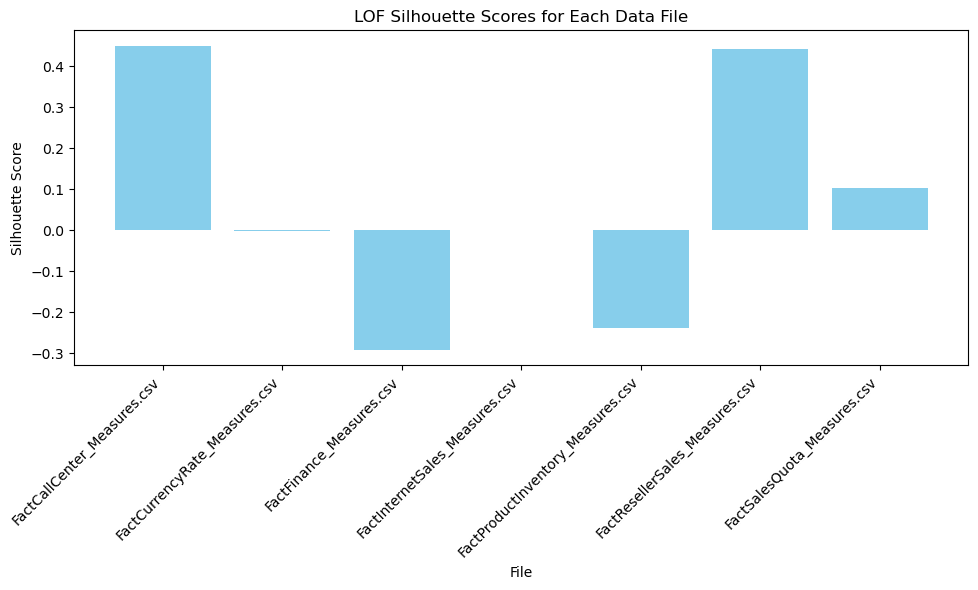

In [41]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import silhouette_score

# Directory containing imputed measures
imputed_measures_dir = "Outlier_Detection_Test_8/Measures_of_fact_tables"
lof_dir = "Outlier_Detection_Test_8/Transaction_Level/LOF_Results"
os.makedirs(lof_dir, exist_ok=True)

# List of CSV files in the imputed measures directory
csv_files = [f for f in os.listdir(imputed_measures_dir) if f.endswith('.csv')]

# Initialize list to store summary data for silhouette scores
silhouette_scores = []

# Function to preprocess data
def preprocess_data(data):
    scaler = StandardScaler()
    return scaler.fit_transform(data)

# Step 1: Hyperparameter Optimization for LOF
def optimize_lof_model(scaled_data):
    param_grid = {
        'n_neighbors': [5, 10, 20],
        'contamination': [0.01, 0.05, 0.1]
    }
    lof_model = LocalOutlierFactor()
    grid_search = GridSearchCV(lof_model, param_grid, scoring='accuracy', cv=5)
    grid_search.fit(scaled_data)
    return grid_search.best_params_

# Step 2: LOF Model Creation and Outlier Detection
def create_lof_model(scaled_data, best_params):
    lof_model = LocalOutlierFactor(n_neighbors=best_params['n_neighbors'], contamination=best_params['contamination'])
    labels = lof_model.fit_predict(scaled_data)
    lof_scores = lof_model.negative_outlier_factor_
    return labels, lof_scores

# Step 3: Evaluate Model and Store Results
def evaluate_and_store_results(data, scaled_data, labels, lof_scores, file_name):
    # Check if there are at least two unique labels for silhouette calculation
    unique_labels = len(set(labels))
    if unique_labels > 1:
        # Calculate Silhouette Score if there are at least two labels
        silhouette_avg = silhouette_score(scaled_data, labels)
        silhouette_scores.append({
            'File': file_name,
            'Silhouette Score': silhouette_avg
        })
    else:
        print(f"Silhouette Score not calculated for {file_name} due to single label in predictions.")
        silhouette_scores.append({
            'File': file_name,
            'Silhouette Score': None  # Indicate that the score was not calculated
        })

    # Append results to the data
    data['LOF_Outlier'] = labels
    data['LOF_Score'] = lof_scores

    # Store the outliers in CSV
    outlier_data = data[data['LOF_Outlier'] == -1]
    lof_output_path = os.path.join(lof_dir, f"{file_name}_LOF_Outliers.csv")
    outlier_data.to_csv(lof_output_path, index=False)
    print(f"Stored LOF results for {file_name} in {lof_output_path}")

    
# Step 4: Iterate over all CSV files and apply LOF
for file in csv_files:
    file_path = os.path.join(imputed_measures_dir, file)
    data = pd.read_csv(file_path)
    
    # Preprocess numeric data, excluding 'ID', 'Key', and 'Number' columns
    numeric_data = data.select_dtypes(include=['number'])
    numeric_data = numeric_data[[col for col in numeric_data.columns if not any(x in col for x in ['ID', 'Key', 'Number'])]]
    
    # Scale the data
    scaled_data = preprocess_data(numeric_data)
    
    # Optimize LOF model
    best_params = optimize_lof_model(scaled_data)
    print(f"Best LOF parameters for {file}: {best_params}")
    
    # Create LOF model and detect outliers
    labels, lof_scores = create_lof_model(scaled_data, best_params)
    
    # Evaluate and store the results
    evaluate_and_store_results(data, scaled_data, labels, lof_scores, file)

# Step 5: Save the summary of silhouette scores
silhouette_summary_df = pd.DataFrame(silhouette_scores)
silhouette_summary_df.to_csv(os.path.join(lof_dir, "LOF_Silhouette_Scores.csv"), index=False)
print("Silhouette scores stored in LOF_Silhouette_Scores.csv")

# Step 6: Plot Silhouette Scores
plt.figure(figsize=(10, 6))
plt.bar(silhouette_summary_df['File'], silhouette_summary_df['Silhouette Score'], color='skyblue')
plt.xlabel('File')
plt.ylabel('Silhouette Score')
plt.title('LOF Silhouette Scores for Each Data File')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Display the chart
plt.show()


**Model  2 - iForest**

C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: _BaseScorer.__call__() missing

Best Isolation Forest parameters for FactCallCenter_Measures.csv: {'contamination': 0.01, 'n_estimators': 100}
Stored Isolation Forest results for FactCallCenter_Measures.csv in Outlier_Detection_Test_8/Transaction_Level/IsolationForest_Results\FactCallCenter_Measures.csv_IsolationForest_Outliers.csv


C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: _BaseScorer.__call__() missing

Best Isolation Forest parameters for FactCurrencyRate_Measures.csv: {'contamination': 0.01, 'n_estimators': 100}
Stored Isolation Forest results for FactCurrencyRate_Measures.csv in Outlier_Detection_Test_8/Transaction_Level/IsolationForest_Results\FactCurrencyRate_Measures.csv_IsolationForest_Outliers.csv


C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: _BaseScorer.__call__() missing

Best Isolation Forest parameters for FactFinance_Measures.csv: {'contamination': 0.01, 'n_estimators': 100}
Stored Isolation Forest results for FactFinance_Measures.csv in Outlier_Detection_Test_8/Transaction_Level/IsolationForest_Results\FactFinance_Measures.csv_IsolationForest_Outliers.csv


C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: _BaseScorer.__call__() missing

Best Isolation Forest parameters for FactInternetSales_Measures.csv: {'contamination': 0.01, 'n_estimators': 100}
Stored Isolation Forest results for FactInternetSales_Measures.csv in Outlier_Detection_Test_8/Transaction_Level/IsolationForest_Results\FactInternetSales_Measures.csv_IsolationForest_Outliers.csv


C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: _BaseScorer.__call__() missing

Best Isolation Forest parameters for FactProductInventory_Measures.csv: {'contamination': 0.01, 'n_estimators': 100}
Stored Isolation Forest results for FactProductInventory_Measures.csv in Outlier_Detection_Test_8/Transaction_Level/IsolationForest_Results\FactProductInventory_Measures.csv_IsolationForest_Outliers.csv


C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: _BaseScorer.__call__() missing

Best Isolation Forest parameters for FactResellerSales_Measures.csv: {'contamination': 0.01, 'n_estimators': 100}
Stored Isolation Forest results for FactResellerSales_Measures.csv in Outlier_Detection_Test_8/Transaction_Level/IsolationForest_Results\FactResellerSales_Measures.csv_IsolationForest_Outliers.csv


C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: _BaseScorer.__call__() missing

Best Isolation Forest parameters for FactSalesQuota_Measures.csv: {'contamination': 0.01, 'n_estimators': 100}
Stored Isolation Forest results for FactSalesQuota_Measures.csv in Outlier_Detection_Test_8/Transaction_Level/IsolationForest_Results\FactSalesQuota_Measures.csv_IsolationForest_Outliers.csv
Silhouette scores stored in IsolationForest_Silhouette_Scores.csv


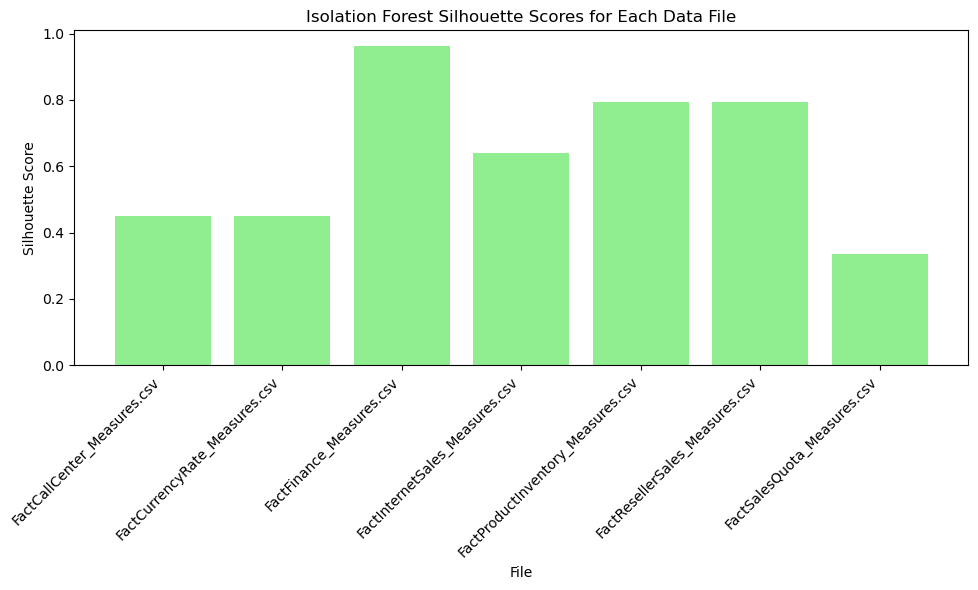

In [42]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import silhouette_score

# Directory containing imputed measures
imputed_measures_dir = "Outlier_Detection_Test_8/Measures_of_fact_tables"
iforest_dir = "Outlier_Detection_Test_8/Transaction_Level/IsolationForest_Results"
os.makedirs(iforest_dir, exist_ok=True)

# List of CSV files in the imputed measures directory
csv_files = [f for f in os.listdir(imputed_measures_dir) if f.endswith('.csv')]

# Initialize list to store summary data for silhouette scores
silhouette_scores = []

# Function to preprocess data
def preprocess_data(data):
    scaler = StandardScaler()
    return scaler.fit_transform(data)

# Step 1: Hyperparameter Optimization for Isolation Forest
def optimize_iforest_model(scaled_data):
    param_grid = {
        'n_estimators': [100, 200],  # Number of trees in the forest
        'contamination': [0.01, 0.05, 0.1]  # Proportion of outliers in the data
    }
    iforest_model = IsolationForest(random_state=42)
    grid_search = GridSearchCV(iforest_model, param_grid, scoring='accuracy', cv=5)
    grid_search.fit(scaled_data)
    return grid_search.best_params_

# Step 2: Isolation Forest Model Creation and Outlier Detection
def create_iforest_model(scaled_data, best_params):
    iforest_model = IsolationForest(n_estimators=best_params['n_estimators'],
                                    contamination=best_params['contamination'],
                                    random_state=42)
    labels = iforest_model.fit_predict(scaled_data)
    decision_function_scores = iforest_model.decision_function(scaled_data)
    return labels, decision_function_scores

# Step 3: Evaluate Model and Store Results
def evaluate_and_store_results(data, scaled_data, labels, decision_function_scores, file_name):
    # Evaluate with Silhouette Score
    silhouette_avg = silhouette_score(scaled_data, labels)
    silhouette_scores.append({
        'File': file_name,
        'Silhouette Score': silhouette_avg
    })

    # Append results to the data
    data['IForest_Outlier'] = labels
    data['IForest_Score'] = decision_function_scores

    # Store the outliers in CSV
    outlier_data = data[data['IForest_Outlier'] == -1]
    iforest_output_path = os.path.join(iforest_dir, f"{file_name}_IsolationForest_Outliers.csv")
    outlier_data.to_csv(iforest_output_path, index=False)
    print(f"Stored Isolation Forest results for {file_name} in {iforest_output_path}")
    
# Step 4: Iterate over all CSV files and apply Isolation Forest
for file in csv_files:
    file_path = os.path.join(imputed_measures_dir, file)
    data = pd.read_csv(file_path)

    # Preprocess numeric data, excluding 'ID', 'Key', and 'Number' columns
    numeric_data = data.select_dtypes(include=['number'])
    numeric_data = numeric_data[[col for col in numeric_data.columns if not any(x in col for x in ['ID', 'Key', 'Number'])]]
    scaled_data = preprocess_data(numeric_data)
    
    # Optimize Isolation Forest model
    best_params = optimize_iforest_model(scaled_data)
    print(f"Best Isolation Forest parameters for {file}: {best_params}")
    
    # Create Isolation Forest model and detect outliers
    labels, decision_function_scores = create_iforest_model(scaled_data, best_params)
    
    # Evaluate and store the results
    evaluate_and_store_results(data, scaled_data, labels, decision_function_scores, file)

# Step 5: Save the summary of silhouette scores
silhouette_summary_df = pd.DataFrame(silhouette_scores)
silhouette_summary_df.to_csv(os.path.join(iforest_dir, "IsolationForest_Silhouette_Scores.csv"), index=False)
print("Silhouette scores stored in IsolationForest_Silhouette_Scores.csv")

# Step 6: Plot Silhouette Scores
plt.figure(figsize=(10, 6))
plt.bar(silhouette_summary_df['File'], silhouette_summary_df['Silhouette Score'], color='lightgreen')
plt.xlabel('File')
plt.ylabel('Silhouette Score')
plt.title('Isolation Forest Silhouette Scores for Each Data File')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Display the chart
plt.show()


**Model 3 - Autoencoder**

C:\Users\ASUS\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Stored Autoencoder results for FactCallCenter_Measures.csv in Outlier_Detection_Test_8/Transaction_Level/Autoencoder_Results\FactCallCenter_Measures.csv_Autoencoder_Outliers.csv
Calculated silhouette score for FactCallCenter_Measures.csv: 0.32262834306100235


C:\Users\ASUS\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


446/446 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Stored Autoencoder results for FactCurrencyRate_Measures.csv in Outlier_Detection_Test_8/Transaction_Level/Autoencoder_Results\FactCurrencyRate_Measures.csv_Autoencoder_Outliers.csv
Calculated silhouette score for FactCurrencyRate_Measures.csv: 0.4312599037294802


C:\Users\ASUS\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1232/1232 ━━━━━━━━━━━━━━━━━━━━ 1s 958us/step
Stored Autoencoder results for FactFinance_Measures.csv in Outlier_Detection_Test_8/Transaction_Level/Autoencoder_Results\FactFinance_Measures.csv_Autoencoder_Outliers.csv
Calculated silhouette score for FactFinance_Measures.csv: 0.8880839627615702


C:\Users\ASUS\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1888/1888 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
Stored Autoencoder results for FactInternetSales_Measures.csv in Outlier_Detection_Test_8/Transaction_Level/Autoencoder_Results\FactInternetSales_Measures.csv_Autoencoder_Outliers.csv
Calculated silhouette score for FactInternetSales_Measures.csv: 0.7196827257406947


C:\Users\ASUS\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


24259/24259 ━━━━━━━━━━━━━━━━━━━━ 23s 932us/step
Stored Autoencoder results for FactProductInventory_Measures.csv in Outlier_Detection_Test_8/Transaction_Level/Autoencoder_Results\FactProductInventory_Measures.csv_Autoencoder_Outliers.csv
Calculated silhouette score for FactProductInventory_Measures.csv: 0.6252918916908857


C:\Users\ASUS\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1902/1902 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
Stored Autoencoder results for FactResellerSales_Measures.csv in Outlier_Detection_Test_8/Transaction_Level/Autoencoder_Results\FactResellerSales_Measures.csv_Autoencoder_Outliers.csv
Calculated silhouette score for FactResellerSales_Measures.csv: 0.7108663265878464


C:\Users\ASUS\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Stored Autoencoder results for FactSalesQuota_Measures.csv in Outlier_Detection_Test_8/Transaction_Level/Autoencoder_Results\FactSalesQuota_Measures.csv_Autoencoder_Outliers.csv
Calculated silhouette score for FactSalesQuota_Measures.csv: 0.26636392117823043
Silhouette scores stored in Autoencoder_Silhouette_Scores.csv


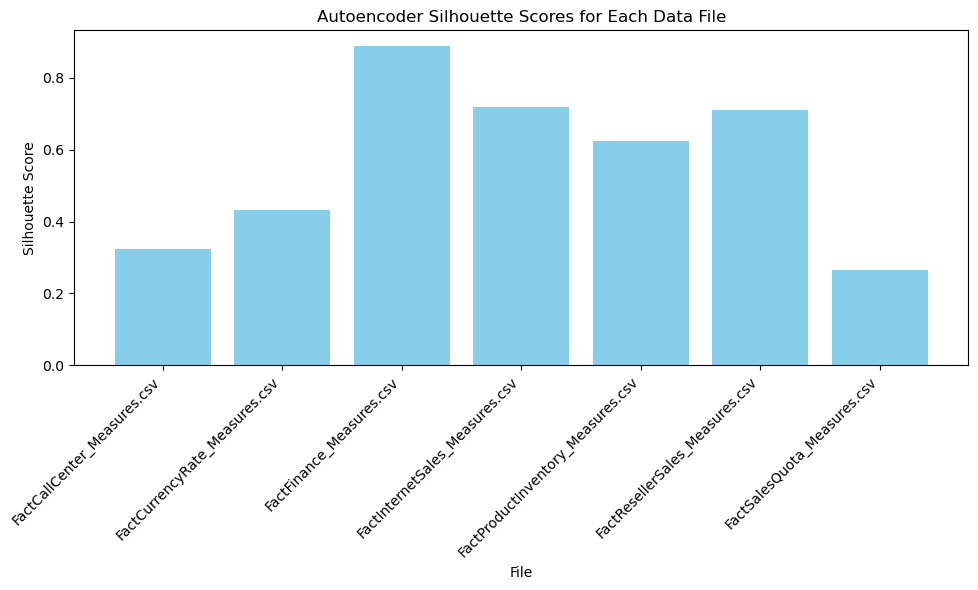

In [43]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import silhouette_score

# Directories
imputed_measures_dir = "Outlier_Detection_Test_8/Measures_of_fact_tables"
autoencoder_dir = "Outlier_Detection_Test_8/Transaction_Level/Autoencoder_Results"
os.makedirs(autoencoder_dir, exist_ok=True)

# List of CSV files in the imputed measures directory
csv_files = [f for f in os.listdir(imputed_measures_dir) if f.endswith('.csv')]

# Initialize list to store summary data for silhouette scores
silhouette_scores = []

# Function to preprocess data
def preprocess_data(data):
    scaler = StandardScaler()
    return scaler.fit_transform(data)

# Build the autoencoder model
def build_autoencoder(input_dim):
    model = Sequential()
    model.add(Dense(units=32, activation='relu', input_dim=input_dim))
    model.add(Dense(units=16, activation='relu'))
    model.add(Dense(units=8, activation='relu'))
    model.add(Dense(units=16, activation='relu'))
    model.add(Dense(units=32, activation='relu'))
    model.add(Dense(units=input_dim, activation='sigmoid'))
    model.compile(optimizer='adam', loss='mse')
    return model

# Function to calculate reconstruction error
def get_reconstruction_errors(model, scaled_data):
    predictions = model.predict(scaled_data)
    mse = np.mean(np.power(scaled_data - predictions, 2), axis=1)
    return mse

# Threshold to define outliers (can be tuned)
def determine_threshold(errors):
    return np.percentile(errors, 95)

# Step 1: Apply autoencoder to each file
for file in csv_files:
    file_path = os.path.join(imputed_measures_dir, file)
    data = pd.read_csv(file_path)

    # Preprocess numeric data, excluding 'ID', 'Key', and 'Number' columns
    numeric_data = data.select_dtypes(include=['number'])
    numeric_data = numeric_data[[col for col in numeric_data.columns if not any(x in col for x in ['ID', 'Key', 'Number'])]]
    scaled_data = preprocess_data(numeric_data)

    # Build and train the autoencoder
    autoencoder = build_autoencoder(scaled_data.shape[1])
    autoencoder.fit(scaled_data, scaled_data, epochs=50, batch_size=32, validation_split=0.1, verbose=0)

    # Get reconstruction errors
    reconstruction_errors = get_reconstruction_errors(autoencoder, scaled_data)

    # Determine outliers based on reconstruction error threshold
    threshold = determine_threshold(reconstruction_errors)
    outliers = reconstruction_errors > threshold

    # Append outlier labels and reconstruction errors to the data
    data['Autoencoder_Outlier'] = np.where(outliers, -1, 1)
    data['Reconstruction_Error'] = reconstruction_errors

    # Store the results
    output_file_path = os.path.join(autoencoder_dir, f"{file}_Autoencoder_Outliers.csv")
    data.to_csv(output_file_path, index=False)
    print(f"Stored Autoencoder results for {file} in {output_file_path}")

    # Calculate silhouette score if there are more than one unique label
    labels = data['Autoencoder_Outlier']
    unique_labels = labels.unique()

    if len(unique_labels) > 1:
        silhouette_avg = silhouette_score(scaled_data, labels)
        silhouette_scores.append({
            'File': file,
            'Silhouette Score': silhouette_avg
        })
        print(f"Calculated silhouette score for {file}: {silhouette_avg}")
    else:
        print(f"Skipping silhouette score for {file} as it contains only one unique label: {unique_labels}")

# Step 2: Save the summary of silhouette scores
silhouette_summary_df = pd.DataFrame(silhouette_scores)
silhouette_summary_df.to_csv(os.path.join(autoencoder_dir, "Autoencoder_Silhouette_Scores.csv"), index=False)
print("Silhouette scores stored in Autoencoder_Silhouette_Scores.csv")

# Step 3: Plot Silhouette Scores
plt.figure(figsize=(10, 6))
plt.bar(silhouette_summary_df['File'], silhouette_summary_df['Silhouette Score'], color='skyblue')
plt.xlabel('File')
plt.ylabel('Silhouette Score')
plt.title('Autoencoder Silhouette Scores for Each Data File')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Display the chart
plt.show()


**Model 4 - OCSVM**

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.svm import OneClassSVM
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import silhouette_score

# Directory containing imputed measures
imputed_measures_dir = "Outlier_Detection_Test_8/Measures_of_fact_tables"
ocsvm_dir = "Outlier_Detection_Test_8/Transaction_Level/OCSVM_Result"
os.makedirs(ocsvm_dir, exist_ok=True)

# List of CSV files in the imputed measures directory
csv_files = [f for f in os.listdir(imputed_measures_dir) if f.endswith('.csv')]

# Initialize list to store summary data for silhouette scores
silhouette_scores = []

# Function to preprocess data
def preprocess_data(data):
    scaler = StandardScaler()
    return scaler.fit_transform(data)

# Step 1: Hyperparameter Optimization for OCSVM
def optimize_ocsvm_model(scaled_data):
    param_grid = {
        'nu': [0.01, 0.05, 0.1],  # Regularization parameter
        'gamma': ['scale', 'auto']  # Kernel coefficient
    }
    ocsvm_model = OneClassSVM()
    grid_search = GridSearchCV(ocsvm_model, param_grid, scoring='accuracy', cv=5)
    grid_search.fit(scaled_data)
    return grid_search.best_params_

# Step 2: OCSVM Model Creation and Outlier Detection
def create_ocsvm_model(scaled_data, best_params):
    ocsvm_model = OneClassSVM(nu=best_params['nu'], gamma=best_params['gamma'])
    labels = ocsvm_model.fit_predict(scaled_data)
    decision_function_scores = ocsvm_model.decision_function(scaled_data)
    return labels, decision_function_scores

# Step 3: Evaluate Model and Store Results
def evaluate_and_store_results(data, scaled_data, labels, decision_function_scores, file_name):
    # Evaluate with Silhouette Score
    silhouette_avg = silhouette_score(scaled_data, labels)
    silhouette_scores.append({
        'File': file_name,
        'Silhouette Score': silhouette_avg
    })

    # Append results to the data
    data['OCSVM_Outlier'] = labels
    data['OCSVM_Score'] = decision_function_scores

    # Store the outliers in CSV
    outlier_data = data[data['OCSVM_Outlier'] == -1]
    ocsvm_output_path = os.path.join(ocsvm_dir, f"{file_name}_OCSVM_Outliers.csv")
    outlier_data.to_csv(ocsvm_output_path, index=False)
    print(f"Stored OCSVM results for {file_name} in {ocsvm_output_path}")
    
# Step 4: Iterate over all CSV files and apply OCSVM
for file in csv_files:
    if file == "FactProductInventory_Imputed_Measures.csv":
        print(f"Skipping {file} as requested.")
        continue
    
    file_path = os.path.join(imputed_measures_dir, file)
    data = pd.read_csv(file_path)
    
    # Preprocess numeric data, excluding 'ID', 'Key', and 'Number' columns
    numeric_data = data.select_dtypes(include=['number'])
    numeric_data = numeric_data[[col for col in numeric_data.columns if not any(x in col for x in ['ID', 'Key', 'Number'])]]
    scaled_data = preprocess_data(numeric_data)
    
    # Optimize OCSVM model
    best_params = optimize_ocsvm_model(scaled_data)
    print(f"Best OCSVM parameters for {file}: {best_params}")
    
    # Create OCSVM model and detect outliers
    labels, decision_function_scores = create_ocsvm_model(scaled_data, best_params)
    
    # Evaluate and store the results
    evaluate_and_store_results(data, scaled_data, labels, decision_function_scores, file)

# Step 5: Save the summary of silhouette scores
silhouette_summary_df = pd.DataFrame(silhouette_scores)
silhouette_summary_df.to_csv(os.path.join(ocsvm_dir, "OCSVM_Silhouette_Scores.csv"), index=False)
print("Silhouette scores stored in OCSVM_Silhouette_Scores.csv")

# Step 6: Plot Silhouette Scores
plt.figure(figsize=(10, 6))
plt.bar(silhouette_summary_df['File'], silhouette_summary_df['Silhouette Score'], color='lightcoral')
plt.xlabel('File')
plt.ylabel('Silhouette Score')
plt.title('OCSVM Silhouette Scores for Each Data File')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Display the chart
plt.show()


C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: _BaseScorer.__call__() missing

Best OCSVM parameters for FactCallCenter_Measures.csv: {'gamma': 'scale', 'nu': 0.01}
Stored OCSVM results for FactCallCenter_Measures.csv in Outlier_Detection_Test_8/Transaction_Level/OCSVM_Result\FactCallCenter_Measures.csv_OCSVM_Outliers.csv


C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: _BaseScorer.__call__() missing

Best OCSVM parameters for FactCurrencyRate_Measures.csv: {'gamma': 'scale', 'nu': 0.01}
Stored OCSVM results for FactCurrencyRate_Measures.csv in Outlier_Detection_Test_8/Transaction_Level/OCSVM_Result\FactCurrencyRate_Measures.csv_OCSVM_Outliers.csv


C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: _BaseScorer.__call__() missing

Best OCSVM parameters for FactFinance_Measures.csv: {'gamma': 'scale', 'nu': 0.01}
Stored OCSVM results for FactFinance_Measures.csv in Outlier_Detection_Test_8/Transaction_Level/OCSVM_Result\FactFinance_Measures.csv_OCSVM_Outliers.csv


C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: _BaseScorer.__call__() missing

Best OCSVM parameters for FactInternetSales_Measures.csv: {'gamma': 'scale', 'nu': 0.01}
Stored OCSVM results for FactInternetSales_Measures.csv in Outlier_Detection_Test_8/Transaction_Level/OCSVM_Result\FactInternetSales_Measures.csv_OCSVM_Outliers.csv


C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: _BaseScorer.__call__() missing

**Create a summary table of 4 models containing the number of detected outliers (Optional)**

In [1]:
import os
import pandas as pd

# Directories where outlier results are stored
lof_dir = "Outlier_Detection_test_8/Transaction_Level/LOF_Results"
iforest_dir = "Outlier_Detection_test_8/Transaction_Level/IsolationForest_Results"
ocsvm_dir = "Outlier_Detection_test_8/Transaction_Level/OCSVM_Result"
autoencoder_dir = "Outlier_Detection_Test_8/Transaction_Level/Autoencoder_Results"

# Initialize a list to hold summary information
summary = []

# Get the list of fact tables 
fact_tables = [f.replace('_LOF_Outliers.csv', '') for f in os.listdir(lof_dir) if f.endswith('_LOF_Outliers.csv')]

# Process each fact table
for table in fact_tables:
    # Initialize the outlier counts for each model
    lof_count = 0
    iforest_count = 0
    ocsvm_count = 0
    autoencoder_count = 0

    # 1. LOF outlier count
    lof_file_path = os.path.join(lof_dir, f"{table}_LOF_Outliers.csv")
    if os.path.exists(lof_file_path):
        lof_data = pd.read_csv(lof_file_path)
        lof_count = len(lof_data)

    # 2. Isolation Forest outlier count
    iforest_file_path = os.path.join(iforest_dir, f"{table}_IsolationForest_Outliers.csv")
    if os.path.exists(iforest_file_path):
        iforest_data = pd.read_csv(iforest_file_path)
        iforest_count = len(iforest_data)

    # 3. OCSVM outlier count
    ocsvm_file_path = os.path.join(ocsvm_dir, f"{table}_OCSVM_Outliers.csv")
    if os.path.exists(ocsvm_file_path):
        ocsvm_data = pd.read_csv(ocsvm_file_path)
        ocsvm_count = len(ocsvm_data)

    # 4. Autoencoder outlier count (only -1 values)
    autoencoder_file_path = os.path.join(autoencoder_dir, f"{table}_Autoencoder_Outliers.csv")
    if os.path.exists(autoencoder_file_path):
        autoencoder_data = pd.read_csv(autoencoder_file_path)
        autoencoder_outliers = autoencoder_data[autoencoder_data['Autoencoder_Outlier'] == -1]
        autoencoder_count = len(autoencoder_outliers)

    # Append the counts to the summary list
    summary.append({
        "Fact Table": table,
        "LOF Outliers": lof_count,
        "Isolation Forest Outliers": iforest_count,
        "OCSVM Outliers": ocsvm_count,
        "Autoencoder Outliers": autoencoder_count
    })

# Convert the summary list to a DataFrame
models_summary_df = pd.DataFrame(summary)

# Save the summary DataFrame to a CSV file
models_summary_df.to_csv("models_outlier_summary.csv", index=False)

# Display the DataFrame for review
print(models_summary_df)


                          Fact Table  LOF Outliers  Isolation Forest Outliers  \
0        FactCallCenter_Measures.csv             2                          2   
1      FactCurrencyRate_Measures.csv           141                        143   
2           FactFinance_Measures.csv           395                        382   
3     FactInternetSales_Measures.csv           604                        396   
4  FactProductInventory_Measures.csv          7717                       7761   
5     FactResellerSales_Measures.csv           608                        606   
6        FactSalesQuota_Measures.csv             2                          2   

   OCSVM Outliers  Autoencoder Outliers  
0              13                     6  
1             191                   714  
2             606                  1969  
3            3138                  2653  
4           38436                 38815  
5             621                  2982  
6              13                     9  


In [2]:
models_summary_df

,Fact Table,LOF Outliers,Isolation Forest Outliers,OCSVM Outliers,Autoencoder Outliers
0,FactCallCenter_Measures.csv,2,2,13,6
1,FactCurrencyRate_Measures.csv,141,143,191,714
2,FactFinance_Measures.csv,395,382,606,1969
3,FactInternetSales_Measures.csv,604,396,3138,2653
4,FactProductInventory_Measures.csv,7717,7761,38436,38815
5,FactResellerSales_Measures.csv,608,606,621,2982
6,FactSalesQuota_Measures.csv,2,2,13,9


**Get the union of the all outliers into one table**

In [14]:
import os
import pandas as pd
import pyodbc

# Directory structure where the outlier results are stored
base_dir = "Outlier_Detection_Test_8/Transaction_Level"
lof_dir = os.path.join(base_dir, "LOF_Results")
ocsvm_dir = os.path.join(base_dir, "OCSVM_Result")
iforest_dir = os.path.join(base_dir, "IsolationForest_Results")
autoencoder_dir = os.path.join(base_dir, "Autoencoder_Results")
combined_dir = os.path.join(base_dir, "Union_of_Outliers")  # Directory for combined results

# Create directories if they don't exist
os.makedirs(combined_dir, exist_ok=True)

# Step 1: Connect to SQL Server
try:
    conn = pyodbc.connect('Driver={SQL Server};'
                          'Server=DESKTOP-J7VSVLC\\SQLEXPRESS;'
                          'Database=AdventureWorksDW2019(1);'
                          'Trusted_Connection=yes;')
    print("Connected Successfully")
except Exception as e:
    print(f"Connection failed: {e}")
    conn = None

# Proceed only if connection is successful
if conn:
    # Step 2: Query to identify all fact tables
    fact_table_query = """
    SELECT 
        TABLE_NAME
    FROM 
        INFORMATION_SCHEMA.TABLES
    WHERE 
        TABLE_TYPE = 'BASE TABLE' AND TABLE_NAME LIKE 'Fact%'
    ORDER BY 
        TABLE_NAME;
    """
    
    # Step 3: Execute query to get fact tables
    fact_tables = pd.read_sql(fact_table_query, conn)
    
    # Step 4: Filter out factless tables by checking for numeric measures
    fact_tables_with_measures = []
    
    for table in fact_tables['TABLE_NAME']:
        # Query to check for numeric columns in each fact table
        column_check_query = f"""
        SELECT COLUMN_NAME, DATA_TYPE
        FROM INFORMATION_SCHEMA.COLUMNS
        WHERE TABLE_NAME = '{table}' AND 
              DATA_TYPE IN ('int', 'smallint', 'tinyint', 'float', 'real', 'decimal', 'numeric', 'money', 'smallmoney')
        """
        
        numeric_columns = pd.read_sql(column_check_query, conn)
        
        if not numeric_columns.empty:
            # Query to identify primary and foreign key columns in the table
            key_columns_query = f"""
            SELECT COLUMN_NAME
            FROM INFORMATION_SCHEMA.KEY_COLUMN_USAGE
            WHERE TABLE_NAME = '{table}'
            """
            
            key_columns = pd.read_sql(key_columns_query, conn)
            
            # Convert key columns to a list for comparison
            key_columns_list = key_columns['COLUMN_NAME'].tolist()
            
            # Check if there are any numeric columns that are not keys
            non_key_numeric_columns = [col for col in numeric_columns['COLUMN_NAME'] if col not in key_columns_list]
            
            # Additional check: Ensure the column names do not contain 'Key'
            non_key_numeric_columns = [col for col in non_key_numeric_columns if 'Key' not in col]
            
            if non_key_numeric_columns:
                fact_tables_with_measures.append(table)
            else:
                print(f"Skipping factless table: {table}")
    
    # Step 5: Process only fact tables with numeric measures and combine the outlier results
    for table in fact_tables_with_measures:
        print(f"Processing table: {table}")
        
        # Step 6: Fetch the fact table data for IDs
        data_query = f"SELECT * FROM {table}"
        data = pd.read_sql(data_query, conn)
        
        # Step 7: Keep 'ID' or 'Key' columns for identification
        id_columns = [col for col in data.columns if 'ID' in col or 'Key' in col]
        if not id_columns:
            print(f"No ID or Key column found for table {table}. Skipping...")
            continue
        
        combined_outliers = pd.DataFrame(data[id_columns + non_key_numeric_columns])  # Start with the ID/Key columns and measures
        
        # Step 8: Load the outlier data for each model
        lof_file_path = os.path.join(lof_dir, f"{table}_Measures.csv_LOF_Outliers.csv")
        iforest_file_path = os.path.join(iforest_dir, f"{table}_Measures.csv_IsolationForest_Outliers.csv")
        ocsvm_file_path = os.path.join(ocsvm_dir, f"{table}_Measures.csv_OCSVM_Outliers.csv")
        autoencoder_file_path = os.path.join(autoencoder_dir, f"{table}_Measures.csv_Autoencoder_Outliers.csv")
        
        # Merge LOF results using FactID (or relevant key) as the merging key
        if os.path.exists(lof_file_path):
            lof_data = pd.read_csv(lof_file_path)
            lof_data = lof_data.rename(columns={'LOF_Outlier': 'LOF_Outlier', 'LOF_Score': 'LOF_Score'})  # Adjust if necessary
            combined_outliers = combined_outliers.merge(lof_data[id_columns + ['LOF_Outlier', 'LOF_Score']], on=id_columns, how='left')
        
        # Merge Isolation Forest results using FactID
        if os.path.exists(iforest_file_path):
            iforest_data = pd.read_csv(iforest_file_path)
            iforest_data = iforest_data.rename(columns={'IForest_Outlier': 'IForest_Outlier', 'IForest_Score': 'IForest_Score'})  # Adjust if necessary
            combined_outliers = combined_outliers.merge(iforest_data[id_columns + ['IForest_Outlier', 'IForest_Score']], on=id_columns, how='left')
        
        # Merge OCSVM results using FactID
        if os.path.exists(ocsvm_file_path):
            ocsvm_data = pd.read_csv(ocsvm_file_path)
            ocsvm_data = ocsvm_data.rename(columns={'OCSVM_Outlier': 'OCSVM_Outlier', 'OCSVM_Score': 'OCSVM_Score'})  # Adjust if necessary
            combined_outliers = combined_outliers.merge(ocsvm_data[id_columns + ['OCSVM_Outlier', 'OCSVM_Score']], on=id_columns, how='left')
        
        # Merge only Autoencoder outliers (where Autoencoder_Outlier == -1)
        if os.path.exists(autoencoder_file_path):
            autoencoder_data = pd.read_csv(autoencoder_file_path)
            autoencoder_outliers = autoencoder_data[autoencoder_data['Autoencoder_Outlier'] == -1]
            combined_outliers = combined_outliers.merge(autoencoder_outliers[id_columns + ['Autoencoder_Outlier', 'Reconstruction_Error']], on=id_columns, how='left')
        
        # Step 9: Save the combined dataset for the current table
        combined_output_path = os.path.join(combined_dir, f"{table}_Combined_Outliers.csv")
        combined_outliers.to_csv(combined_output_path, index=False)
        print(f"Stored combined dataset for {table} in {combined_output_path}")
    
    # Step 10: Close the connection
    conn.close()
else:
    print("Database connection failed.")


Connected Successfully


C:\Users\ASUS\AppData\Local\Temp\ipykernel_7172\3926396760.py:42: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  fact_tables = pd.read_sql(fact_table_query, conn)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_7172\3926396760.py:56: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  numeric_columns = pd.read_sql(column_check_query, conn)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_7172\3926396760.py:66: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  key_columns = pd.read_sql(key_columns_query, conn)


Skipping factless table: FactAdditionalInternationalProductDescription
Skipping factless table: FactInternetSalesReason
Skipping factless table: FactSurveyResponse
Processing table: FactCallCenter
Stored combined dataset for FactCallCenter in Outlier_Detection_Test_8/Transaction_Level\Union_of_Outliers\FactCallCenter_Combined_Outliers.csv
Processing table: FactCurrencyRate
Stored combined dataset for FactCurrencyRate in Outlier_Detection_Test_8/Transaction_Level\Union_of_Outliers\FactCurrencyRate_Combined_Outliers.csv
Processing table: FactFinance


C:\Users\ASUS\AppData\Local\Temp\ipykernel_7172\3926396760.py:88: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  data = pd.read_sql(data_query, conn)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_7172\3926396760.py:88: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  data = pd.read_sql(data_query, conn)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_7172\3926396760.py:88: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  data = pd.read_sql(data_query, conn)


Stored combined dataset for FactFinance in Outlier_Detection_Test_8/Transaction_Level\Union_of_Outliers\FactFinance_Combined_Outliers.csv
Processing table: FactInternetSales


C:\Users\ASUS\AppData\Local\Temp\ipykernel_7172\3926396760.py:88: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  data = pd.read_sql(data_query, conn)


Stored combined dataset for FactInternetSales in Outlier_Detection_Test_8/Transaction_Level\Union_of_Outliers\FactInternetSales_Combined_Outliers.csv
Processing table: FactProductInventory


C:\Users\ASUS\AppData\Local\Temp\ipykernel_7172\3926396760.py:88: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  data = pd.read_sql(data_query, conn)


Stored combined dataset for FactProductInventory in Outlier_Detection_Test_8/Transaction_Level\Union_of_Outliers\FactProductInventory_Combined_Outliers.csv
Processing table: FactResellerSales


C:\Users\ASUS\AppData\Local\Temp\ipykernel_7172\3926396760.py:88: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  data = pd.read_sql(data_query, conn)


Stored combined dataset for FactResellerSales in Outlier_Detection_Test_8/Transaction_Level\Union_of_Outliers\FactResellerSales_Combined_Outliers.csv
Processing table: FactSalesQuota
Stored combined dataset for FactSalesQuota in Outlier_Detection_Test_8/Transaction_Level\Union_of_Outliers\FactSalesQuota_Combined_Outliers.csv


C:\Users\ASUS\AppData\Local\Temp\ipykernel_7172\3926396760.py:88: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  data = pd.read_sql(data_query, conn)


**Get the intersection of the outliers detected by the number of models**

In [15]:
import os
import pandas as pd
import pyodbc

# Directory structure where the outlier results are stored
base_dir = "Outlier_Detection_Test_8/Transaction_Level/Union_of_Outliers"
summary_output_dir = "Outlier_Detection_Test_8"  # Directory for saving the summary table

# Create directories if they don't exist
os.makedirs(summary_output_dir, exist_ok=True)

# Initialize a list to store summary information
summary = []

# Step 1: Get the list of combined outlier files from the Union_of_Outliers directory
combined_files = [f for f in os.listdir(base_dir) if f.endswith('_Combined_Outliers.csv')]

# Step 2: Process each combined file and calculate the summary statistics
for file in combined_files:
    # Extract fact table name from the filename
    table_name = file.replace('_Combined_Outliers.csv', '')
    
    # Load the combined outlier data
    file_path = os.path.join(base_dir, file)
    combined_data = pd.read_csv(file_path)
    
    # Count how many models flagged each row as an outlier (-1 for LOF, IF, OCSVM and Autoencoder)
    # Create a new column 'Outlier_Count' that counts how many models detected an outlier
    combined_data['Outlier_Count'] = (
        (combined_data['LOF_Outlier'] == -1).astype(int) +
        (combined_data['IForest_Outlier'] == -1).astype(int) +
        (combined_data['OCSVM_Outlier'] == -1).astype(int) +
        (combined_data['Autoencoder_Outlier'] == -1).astype(int)
    )
    
    # Count the number of rows where:
    # - 4 models detected an outlier
    count_4_models = (combined_data['Outlier_Count'] == 4).sum()
    
    # - At least 3 models detected an outlier
    count_3_models = (combined_data['Outlier_Count'] >= 3).sum()
    
    # - At least 2 models detected an outlier
    count_2_models = (combined_data['Outlier_Count'] >= 2).sum()
    
    # - At least 1 model detected an outlier
    count_1_model = (combined_data['Outlier_Count'] >= 1).sum()
    
    # Append the results for this fact table to the summary list
    summary.append({
        'Fact Table': table_name,
        'Detected by 4 Models': count_4_models,
        'Detected by at least 3 Models': count_3_models,
        'Detected by at least 2 Models': count_2_models,
        'Detected by at least 1 Model': count_1_model
    })

# Step 3: Convert the summary list to a DataFrame
summary_df = pd.DataFrame(summary)

# Step 4: Save the summary DataFrame as a CSV file
summary_output_path = os.path.join(summary_output_dir, 'Outlier_Summary.csv')
summary_df.to_csv(summary_output_path, index=False)

print(f"Summary table saved to {summary_output_path}")

# Display the summary table
print(summary_df)


Summary table saved to Outlier_Detection_Test_8\Outlier_Summary.csv
             Fact Table  Detected by 4 Models  Detected by at least 3 Models  \
0        FactCallCenter                     0                              2   
1      FactCurrencyRate                     0                             40   
2           FactFinance                     0                            206   
3     FactInternetSales                     0                             21   
4  FactProductInventory                     0                           5229   
5     FactResellerSales                    35                            276   
6        FactSalesQuota                     0                              0   

   Detected by at least 2 Models  Detected by at least 1 Model  
0                              4                            17  
1                            194                           955  
2                            786                          2360  
3                           201

In [16]:
summary_df

,Fact Table,Detected by 4 Models,Detected by at least 3 Models,Detected by at least 2 Models,Detected by at least 1 Model
0,FactCallCenter,0,2,4,17
1,FactCurrencyRate,0,40,194,955
2,FactFinance,0,206,786,2360
3,FactInternetSales,0,21,2016,4754
4,FactProductInventory,0,5229,18828,68672
5,FactResellerSales,35,276,879,3634
6,FactSalesQuota,0,0,3,23


**Using a threshold value, select the final outliers**

In [18]:
import os
import pandas as pd

# Directory structure where the outlier results are stored
base_dir = "Outlier_Detection_Test_8/Transaction_Level/Union_of_Outliers"
final_outlier_dir = "Outlier_Detection_Test_8/Final_Outliers"  # Directory for saving the final outliers

# Create directories if they don't exist
os.makedirs(final_outlier_dir, exist_ok=True)

# Load the summary table
summary_output_path = "Outlier_Detection_Test_8/Outlier_Summary.csv"
summary_df = pd.read_csv(summary_output_path)

# Now, iterate through each fact table, load its combined outlier dataset, and select final outliers
for index, row in summary_df.iterrows():
    fact_table = row['Fact Table']
    
    # Load the combined outlier dataset for the current fact table
    combined_outlier_path = os.path.join(base_dir, f"{fact_table}_Combined_Outliers.csv")
    combined_df = pd.read_csv(combined_outlier_path)
    
    # Count how many models detected an outlier for each transaction
    combined_df['Outlier_Count'] = (
        (combined_df['LOF_Outlier'] == -1).astype(int) +
        (combined_df['IForest_Outlier'] == -1).astype(int) +
        (combined_df['OCSVM_Outlier'] == -1).astype(int) +
        (combined_df['Autoencoder_Outlier'] == True).astype(int)
    )
    
    # Calculate outliers detected by each threshold
    outliers_4_models = (combined_df['Outlier_Count'] == 4).sum()
    outliers_3_models = (combined_df['Outlier_Count'] >= 3).sum()
    outliers_2_models = (combined_df['Outlier_Count'] >= 2).sum()
    total_outliers = combined_df['Outlier_Count'].sum()

    # Determine threshold based on percentage-based conditions
    if outliers_4_models > 0.1 * total_outliers:  # If 10% of total outliers are detected by 4 models
        threshold = 4
    elif outliers_3_models > 0.1 * total_outliers:  # If 10% are detected by 3 or more models
        threshold = 3
    elif outliers_2_models > 0.1 * total_outliers:  # If 10% are detected by 2 or more models
        threshold = 2
    else:
        threshold = 1
    
    # Mark the final outliers based on the threshold
    combined_df['Final_Outlier'] = combined_df['Outlier_Count'].apply(lambda x: 1 if x >= threshold else 0)
    
    # Add the threshold value as a column in the dataset
    combined_df['Threshold'] = threshold
    
    # Save the final outliers to a new CSV file
    final_outlier_output_path = os.path.join(final_outlier_dir, f"{fact_table}_Final_Outliers.csv")
    combined_df.to_csv(final_outlier_output_path, index=False)
    
    print(f"Final outliers for {fact_table} saved to {final_outlier_output_path} with threshold {threshold}")


Final outliers for FactCallCenter saved to Outlier_Detection_Test_8/Final_Outliers\FactCallCenter_Final_Outliers.csv with threshold 2
Final outliers for FactCurrencyRate saved to Outlier_Detection_Test_8/Final_Outliers\FactCurrencyRate_Final_Outliers.csv with threshold 1
Final outliers for FactFinance saved to Outlier_Detection_Test_8/Final_Outliers\FactFinance_Final_Outliers.csv with threshold 2
Final outliers for FactInternetSales saved to Outlier_Detection_Test_8/Final_Outliers\FactInternetSales_Final_Outliers.csv with threshold 1
Final outliers for FactProductInventory saved to Outlier_Detection_Test_8/Final_Outliers\FactProductInventory_Final_Outliers.csv with threshold 2
Final outliers for FactResellerSales saved to Outlier_Detection_Test_8/Final_Outliers\FactResellerSales_Final_Outliers.csv with threshold 2
Final outliers for FactSalesQuota saved to Outlier_Detection_Test_8/Final_Outliers\FactSalesQuota_Final_Outliers.csv with threshold 1


In [20]:
import os
import pandas as pd

# Directory structure where the outlier results are stored
base_dir = "Outlier_Detection_Test_8/Transaction_Level/Union_of_Outliers"
final_outlier_dir = "Outlier_Detection_Test_8/Final_Outliers"  # Directory for saving the final outliers
only_final_outliers_dir = "Outlier_Detection_Test_8/Only_Final_Outliers"  # Directory to store only final outliers for analysis

# Create directories if they don't exist
os.makedirs(final_outlier_dir, exist_ok=True)
os.makedirs(only_final_outliers_dir, exist_ok=True)

# Load the summary table
summary_output_path = "Outlier_Detection_Test_4/Outlier_Summary.csv"
summary_df = pd.read_csv(summary_output_path)

# Now, iterate through each fact table, load its combined outlier dataset, and select final outliers
for index, row in summary_df.iterrows():
    fact_table = row['Fact Table']
    
    # Load the combined outlier dataset for the current fact table
    combined_outlier_path = os.path.join(base_dir, f"{fact_table}_Combined_Outliers.csv")
    combined_df = pd.read_csv(combined_outlier_path)
    
    # Count how many models detected an outlier for each transaction
    combined_df['Outlier_Count'] = (
        (combined_df['LOF_Outlier'] == -1).astype(int) +
        (combined_df['IForest_Outlier'] == -1).astype(int) +
        (combined_df['OCSVM_Outlier'] == -1).astype(int) +
        (combined_df['Autoencoder_Outlier'] == True).astype(int)
    )
    
    # Calculate outliers detected by each threshold
    outliers_4_models = (combined_df['Outlier_Count'] == 4).sum()
    outliers_3_models = (combined_df['Outlier_Count'] >= 3).sum()
    outliers_2_models = (combined_df['Outlier_Count'] >= 2).sum()
    total_outliers = combined_df['Outlier_Count'].sum()

    # Determine threshold based on percentage-based conditions
    if outliers_4_models > 0.1 * total_outliers:  # If 10% of total outliers are detected by 4 models
        threshold = 4
    elif outliers_3_models > 0.1 * total_outliers:  # If 10% are detected by 3 or more models
        threshold = 3
    elif outliers_2_models > 0.1 * total_outliers:  # If 10% are detected by 2 or more models
        threshold = 2
    else:
        threshold = 1
    
    # Mark the final outliers based on the threshold
    combined_df['Final_Outlier'] = combined_df['Outlier_Count'].apply(lambda x: 1 if x >= threshold else 0)
    
    # Add the threshold value as a column in the dataset
    combined_df['Threshold'] = threshold
    
    # Save the final outliers to a new CSV file
    final_outlier_output_path = os.path.join(final_outlier_dir, f"{fact_table}_Final_Outliers.csv")
    combined_df.to_csv(final_outlier_output_path, index=False)
    
    # Extract only the rows where 'Final_Outlier' is 1 (i.e., only final outliers)
    only_final_outliers_df = combined_df[combined_df['Final_Outlier'] == 1]
    
    # Save only the final outliers to a new CSV file for analysis
    only_final_outliers_output_path = os.path.join(only_final_outliers_dir, f"{fact_table}_Only_Final_Outliers.csv")
    only_final_outliers_df.to_csv(only_final_outliers_output_path, index=False)
    
    print(f"Final outliers for {fact_table} saved to {final_outlier_output_path} with threshold {threshold}")
    print(f"Only final outliers for {fact_table} saved to {only_final_outliers_output_path}")


Final outliers for FactCallCenter saved to Outlier_Detection_Test_8/Final_Outliers\FactCallCenter_Final_Outliers.csv with threshold 2
Only final outliers for FactCallCenter saved to Outlier_Detection_Test_8/Only_Final_Outliers\FactCallCenter_Only_Final_Outliers.csv
Final outliers for FactCurrencyRate saved to Outlier_Detection_Test_8/Final_Outliers\FactCurrencyRate_Final_Outliers.csv with threshold 1
Only final outliers for FactCurrencyRate saved to Outlier_Detection_Test_8/Only_Final_Outliers\FactCurrencyRate_Only_Final_Outliers.csv
Final outliers for FactFinance saved to Outlier_Detection_Test_8/Final_Outliers\FactFinance_Final_Outliers.csv with threshold 2
Only final outliers for FactFinance saved to Outlier_Detection_Test_8/Only_Final_Outliers\FactFinance_Only_Final_Outliers.csv
Final outliers for FactInternetSales saved to Outlier_Detection_Test_8/Final_Outliers\FactInternetSales_Final_Outliers.csv with threshold 1
Only final outliers for FactInternetSales saved to Outlier_Detecti

**Root Causes using SHAP**

In [ ]:
import os
import pandas as pd
import pyodbc
import shap
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# SQL connection settings (modify according to your environment)
conn_str = 'Driver={SQL Server};Server=DESKTOP-J7VSVLC\\SQLEXPRESS;Database=AdventureWorksDW2019(1);Trusted_Connection=yes;'

# Directory where final outliers are stored
only_final_outliers_dir = "Outlier_Detection_Test_8/Only_Final_Outliers"
shap_plots_dir = "Outlier_Detection_Test_8/SHAP/SHAP_Plots"  # Directory for saving SHAP plots
shap_values_dir = "Outlier_Detection_Test_8/SHAP/SHAP_Values"

# Create directory for SHAP plots if it doesn't exist
os.makedirs(shap_plots_dir, exist_ok=True)
os.makedirs(shap_values_dir, exist_ok=True)

# List of final outlier files
final_outlier_files = [f for f in os.listdir(only_final_outliers_dir) if f.endswith('_Only_Final_Outliers.csv')]

# Step 1: Connect to SQL Server
try:
    conn = pyodbc.connect(conn_str)
    print("Connected Successfully to the database")
except Exception as e:
    print(f"Connection failed: {e}")
    conn = None

if conn:
    # Function to load the original measures from the data warehouse using IDs/Keys
    def load_measures_from_datawarehouse(id_column, keys, table, conn):
        # Convert keys to a comma-separated string for the SQL IN clause
        keys_str = ','.join([f"'{key}'" for key in keys])
        
        # SQL query to retrieve the measures based on the keys
        query = f"""
        SELECT *
        FROM {table}
        WHERE {id_column} IN ({keys_str})
        """
        
        # Execute the query and load the data
        measures_df = pd.read_sql(query, conn)
        
        # Drop ID/Key columns to retain only the measures (features)
        feature_columns = measures_df.select_dtypes(include=['float64', 'int64']).columns.tolist()
        feature_columns = [col for col in feature_columns if 'Key' not in col and 'ID' not in col]
        
        return measures_df[feature_columns]
    
    # Loop through each final outlier file
    for file in final_outlier_files:
        fact_table = file.replace('_Only_Final_Outliers.csv', '')

        # Skip FactProductInventory table
        if fact_table == "FactProductInventory":
            print(f"Skipping SHAP analysis for {fact_table}")
            continue

        file_path = os.path.join(only_final_outliers_dir, file)
        
        # Load the final outliers data
        final_outliers_df = pd.read_csv(file_path)
        
        # Identify the ID or Key column for identification
        id_columns = [col for col in final_outliers_df.columns if 'ID' in col or 'Key' in col]
        if not id_columns:
            print(f"No ID/Key columns found for table {fact_table}. Skipping...")
            continue
        id_column = id_columns[0]  # Assuming the first ID/Key column
        
        # Extract the relevant keys of the final outliers
        final_outlier_keys = final_outliers_df[id_column].unique()
        
        # Load the original measures (features) for the final outliers from the database
        features_df = load_measures_from_datawarehouse(id_column, final_outlier_keys, fact_table, conn)
        
        if features_df.empty:
            print(f"No measures available for table {fact_table}. Skipping SHAP analysis...")
            continue
        
        # Handle missing values by imputing (filling in) them using the mean value
        imputer = SimpleImputer(strategy='mean')
        features_df_imputed = pd.DataFrame(imputer.fit_transform(features_df), columns=features_df.columns)
        
        # Split the data into training and test sets (using all the final outliers as test set here for SHAP analysis)
        X_train, X_test = train_test_split(features_df_imputed, test_size=0.2, random_state=42)

        # Standardize the data for the model
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # Train an Isolation Forest model (as a proxy for SHAP analysis, you could choose another)
        model = IsolationForest(contamination=0.05, random_state=42)
        model.fit(X_train_scaled)

        # Use SHAP to explain the model's predictions
        explainer = shap.KernelExplainer(model.predict, X_train_scaled)
        shap_values = explainer.shap_values(X_test_scaled)

        # Plot SHAP summary for the test set (the final outliers)
        print(f"SHAP analysis for {fact_table}")
        
        # Create a summary plot and save it as an image file
        shap_summary_plot_path = os.path.join(shap_plots_dir, f"{fact_table}_SHAP_Summary.png")
        
        # Generate and save SHAP plot
        plt.figure()
        shap.summary_plot(shap_values, X_test_scaled, feature_names=features_df.columns, show=False)
        plt.savefig(shap_summary_plot_path, bbox_inches='tight')
        plt.close()  # Close the plot to free memory
        
        # Save SHAP values for further analysis
        shap_values_df = pd.DataFrame(shap_values, columns=features_df.columns)
        shap_values_output_path = os.path.join(shap_values_dir, f"{fact_table}_SHAP_Values.csv")
        shap_values_df.to_csv(shap_values_output_path, index=False)
        
        print(f"SHAP values for {fact_table} saved to {shap_values_output_path}")
        print(f"SHAP summary plot for {fact_table} saved to {shap_summary_plot_path}")
    
    # Step 2: Close the database connection
    conn.close()

else:
    print("Database connection failed.")


Connected Successfully to the database


C:\Users\ASUS\AppData\Local\Temp\ipykernel_22708\779483725.py:48: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  measures_df = pd.read_sql(query, conn)


  0%|          | 0/1 [00:00<?, ?it/s]

SHAP analysis for FactCallCenter
SHAP values for FactCallCenter saved to Outlier_Detection_Test_8/SHAP/SHAP_Values\FactCallCenter_SHAP_Values.csv
SHAP summary plot for FactCallCenter saved to Outlier_Detection_Test_8/SHAP/SHAP_Plots\FactCallCenter_SHAP_Summary.png


C:\Users\ASUS\AppData\Local\Temp\ipykernel_22708\779483725.py:48: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  measures_df = pd.read_sql(query, conn)
Using 5558 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1390 [00:00<?, ?it/s]

SHAP analysis for FactCurrencyRate
SHAP values for FactCurrencyRate saved to Outlier_Detection_Test_8/SHAP/SHAP_Values\FactCurrencyRate_SHAP_Values.csv
SHAP summary plot for FactCurrencyRate saved to Outlier_Detection_Test_8/SHAP/SHAP_Plots\FactCurrencyRate_SHAP_Summary.png


C:\Users\ASUS\AppData\Local\Temp\ipykernel_22708\779483725.py:48: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  measures_df = pd.read_sql(query, conn)
Using 164 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/42 [00:00<?, ?it/s]

SHAP analysis for FactFinance
SHAP values for FactFinance saved to Outlier_Detection_Test_8/SHAP/SHAP_Values\FactFinance_SHAP_Values.csv
SHAP summary plot for FactFinance saved to Outlier_Detection_Test_8/SHAP/SHAP_Plots\FactFinance_SHAP_Summary.png


C:\Users\ASUS\AppData\Local\Temp\ipykernel_22708\779483725.py:48: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  measures_df = pd.read_sql(query, conn)
Using 45017 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/11255 [00:00<?, ?it/s]

**Aggregation level one**

In [1]:
import os
import pandas as pd
import pyodbc
import shap
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# SQL connection settings (modify according to your environment)
conn_str = 'Driver={SQL Server};Server=DESKTOP-J7VSVLC\\SQLEXPRESS;Database=AdventureWorksDW2019(1);Trusted_Connection=yes;'

# Directory where final outliers are stored
only_final_outliers_dir = "Outlier_Detection_Test_8/Only_Final_Outliers"
shap_plots_dir = "Outlier_Detection_Test_8/New_SHAP/SHAP_Plots"  # Directory for saving SHAP plots
shap_values_dir = "Outlier_Detection_Test_8/New_SHAP/SHAP_Values"

# Create directories if they don't exist
os.makedirs(shap_plots_dir, exist_ok=True)
os.makedirs(shap_values_dir, exist_ok=True)

# Step 1: Connect to SQL Server
try:
    conn = pyodbc.connect(conn_str)
    print("Connected Successfully to the database")
except Exception as e:
    print(f"Connection failed: {e}")
    conn = None

if conn:
    # Function to load the original measures from the data warehouse using IDs/Keys
    def load_measures_from_datawarehouse(id_column, keys, table, conn):
        # Convert keys to a comma-separated string for the SQL IN clause
        keys_str = ','.join([f"'{key}'" for key in keys])
        
        # SQL query to retrieve the measures based on the keys
        query = f"""
        SELECT *
        FROM {table}
        WHERE {id_column} IN ({keys_str})
        """
        
        # Execute the query and load the data
        measures_df = pd.read_sql(query, conn)
        
        # Drop ID/Key columns to retain only the measures (features)
        feature_columns = measures_df.select_dtypes(include=['float64', 'int64']).columns.tolist()
        feature_columns = [col for col in feature_columns if 'Key' not in col and 'ID' not in col]
        
        return measures_df[feature_columns]
    
    # Target table: FactInternetSales
    fact_table = "FactInternetSales"
    file = f"{fact_table}_Only_Final_Outliers.csv"
    file_path = os.path.join(only_final_outliers_dir, file)

    # Check if the file exists
    if not os.path.exists(file_path):
        print(f"Outlier file for {fact_table} not found. Skipping...")
    else:
        # Load the final outliers data
        final_outliers_df = pd.read_csv(file_path)
        
        # Identify the ID or Key column for identification
        id_columns = [col for col in final_outliers_df.columns if 'ID' in col or 'Key' in col]
        if not id_columns:
            print(f"No ID/Key columns found for table {fact_table}. Skipping...")
        else:
            id_column = id_columns[0]  # Assuming the first ID/Key column
            
            # Extract the relevant keys of the final outliers
            final_outlier_keys = final_outliers_df[id_column].unique()
            
            # Load the original measures (features) for the final outliers from the database
            features_df = load_measures_from_datawarehouse(id_column, final_outlier_keys, fact_table, conn)
            
            if features_df.empty:
                print(f"No measures available for table {fact_table}. Skipping SHAP analysis...")
            else:
                # Handle missing values by imputing (filling in) them using the mean value
                imputer = SimpleImputer(strategy='mean')
                features_df_imputed = pd.DataFrame(imputer.fit_transform(features_df), columns=features_df.columns)
                
                # Split the data into training and test sets (using all the final outliers as test set here for SHAP analysis)
                X_train, X_test = train_test_split(features_df_imputed, test_size=0.2, random_state=42)

                # Standardize the data for the model
                scaler = StandardScaler()
                X_train_scaled = scaler.fit_transform(X_train)
                X_test_scaled = scaler.transform(X_test)

                # Train an Isolation Forest model (as a proxy for SHAP analysis, you could choose another)
                model = IsolationForest(contamination=0.05, random_state=42)
                model.fit(X_train_scaled)

                # Use SHAP to explain the model's predictions
                explainer = shap.KernelExplainer(model.predict, X_train_scaled)
                shap_values = explainer.shap_values(X_test_scaled)

                # Plot SHAP summary for the test set (the final outliers)
                print(f"SHAP analysis for {fact_table}")
                
                # Create a summary plot and save it as an image file
                shap_summary_plot_path = os.path.join(shap_plots_dir, f"{fact_table}_SHAP_Summary.png")
                
                # Generate and save SHAP plot
                plt.figure()
                shap.summary_plot(shap_values, X_test_scaled, feature_names=features_df.columns, show=False)
                plt.savefig(shap_summary_plot_path, bbox_inches='tight')
                plt.close()  # Close the plot to free memory
                
                # Save SHAP values for further analysis
                shap_values_df = pd.DataFrame(shap_values, columns=features_df.columns)
                shap_values_output_path = os.path.join(shap_values_dir, f"{fact_table}_SHAP_Values.csv")
                shap_values_df.to_csv(shap_values_output_path, index=False)
                
                print(f"SHAP values for {fact_table} saved to {shap_values_output_path}")
                print(f"SHAP summary plot for {fact_table} saved to {shap_summary_plot_path}")
    
    # Step 2: Close the database connection
    conn.close()

else:
    print("Database connection failed.")


Connected Successfully to the database


C:\Users\ASUS\AppData\Local\Temp\ipykernel_18960\2313468327.py:45: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  measures_df = pd.read_sql(query, conn)
Using 45017 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/11255 [00:00<?, ?it/s]


KeyboardInterrupt



In [1]:
import pyodbc
import pandas as pd
import os
import re

# Step 1: Connect to SQL Server
try:
    conn = pyodbc.connect('Driver={SQL Server};'
                          'Server=DESKTOP-J7VSVLC\\SQLEXPRESS;'
                          'Database=AdventureWorksDW2019(1);'
                          'Trusted_Connection=yes;')
    print("Connected Successfully")
except Exception as e:
    print(f"Connection failed: {e}")
    conn = None

# Proceed only if connection is successful
if conn:
    # Base directory for final outliers
    all_final_outliers_dir = "Outlier_Detection_Test_8/Only_Final_Outliers"
    
    # Directory for aggregated results
    aggregated_dir = "Outlier_Detection_Test_8/Aggregated_By_One_Category"
    os.makedirs(aggregated_dir, exist_ok=True)

    # Step 2: Identify dimension tables and their categorical columns
    dim_tables_query = """
    SELECT TABLE_NAME, COLUMN_NAME
    FROM INFORMATION_SCHEMA.COLUMNS
    WHERE TABLE_NAME IN (
        SELECT TABLE_NAME 
        FROM INFORMATION_SCHEMA.TABLES 
        WHERE TABLE_TYPE = 'BASE TABLE' AND TABLE_NAME LIKE 'Dim%'
    )
    AND DATA_TYPE IN ('varchar', 'nvarchar', 'char', 'text')
    """
    
    dim_columns_df = pd.read_sql(dim_tables_query, conn)
    
    # Step 3: Filter out non-English columns and columns containing specified substrings
    non_english_pattern = re.compile(r'[^\x00-\x7F]+')
    
    # Function to check if a column name contains non-English characters or specified substrings
    def is_valid_column(column_name):
        substrings_to_remove = ['Description', 'FirstName', 'MiddleName', 'PhoneNumber', 'Phone', 'LastName', 'Address', 'ID', 'Key']
        if non_english_pattern.search(column_name):
            return False
        if any(substring in column_name for substring in substrings_to_remove):
            return False
        return True

    # Filter valid columns
    dim_columns_df = dim_columns_df[dim_columns_df['COLUMN_NAME'].apply(is_valid_column)]

    # Step 4: Process each fact table and dynamically join with dimension tables
    for file in os.listdir(all_final_outliers_dir):
        if file.endswith("_Only_Final_Outliers.csv"):
            # Extract the fact table name from the file
            table = file.replace("_Only_Final_Outliers.csv", "")
            agreed_outlier_file_path = os.path.join(all_final_outliers_dir, file)
            
            if os.path.exists(agreed_outlier_file_path):
                # Load the final outliers CSV file
                outlier_data = pd.read_csv(agreed_outlier_file_path)

                # Dynamically join outlier data with each dimension table based on foreign key
                for dim_table, dim_column in dim_columns_df.groupby('TABLE_NAME'):
                    categorical_columns = dim_column['COLUMN_NAME'].tolist()
                    
                    # Generate the query to get the dimension data
                    dim_data_query = f"SELECT * FROM {dim_table}"
                    dim_data = pd.read_sql(dim_data_query, conn)

                    # Determine the common foreign key column
                    foreign_keys = set(outlier_data.columns).intersection(set(dim_data.columns))
                    if foreign_keys:
                        foreign_key = foreign_keys.pop()
                        
                        # Merge outlier data with dimension table data on the foreign key
                        merged_data = pd.merge(outlier_data, dim_data, left_on=foreign_key, right_on=foreign_key, how='inner')

                        # Group by the categorical columns
                        for cat_column in categorical_columns:
                            aggregated_data = merged_data.groupby(cat_column).size().reset_index(name='OutlierCount')

                            # Save aggregated results to CSV
                            aggregated_output_path = os.path.join(aggregated_dir, f"{table}_Aggregated_By_{dim_table}_{cat_column}.csv")
                            aggregated_data.to_csv(aggregated_output_path, index=False)
                            print(f"Stored aggregated results for {table} by {dim_table}.{cat_column} in {aggregated_output_path}.")
                    else:
                        print(f"No common foreign key found for table {table} and dimension table {dim_table}. Skipping...")
            else:
                print(f"No agreed outliers file found for {table}. Skipping...")

    # Close the database connection
    conn.close()
else:
    print("Database connection failed.")


Connected Successfully


C:\Users\ASUS\AppData\Local\Temp\ipykernel_15672\2467355469.py:38: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  dim_columns_df = pd.read_sql(dim_tables_query, conn)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_15672\2467355469.py:72: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  dim_data = pd.read_sql(dim_data_query, conn)


No common foreign key found for table FactCallCenter and dimension table DimAccount. Skipping...
No common foreign key found for table FactCallCenter and dimension table DimCurrency. Skipping...
No common foreign key found for table FactCallCenter and dimension table DimCustomer. Skipping...
Stored aggregated results for FactCallCenter by DimDate.EnglishDayNameOfWeek in Outlier_Detection_Test_8/Aggregated_By_One_Category\FactCallCenter_Aggregated_By_DimDate_EnglishDayNameOfWeek.csv.
Stored aggregated results for FactCallCenter by DimDate.SpanishDayNameOfWeek in Outlier_Detection_Test_8/Aggregated_By_One_Category\FactCallCenter_Aggregated_By_DimDate_SpanishDayNameOfWeek.csv.
Stored aggregated results for FactCallCenter by DimDate.FrenchDayNameOfWeek in Outlier_Detection_Test_8/Aggregated_By_One_Category\FactCallCenter_Aggregated_By_DimDate_FrenchDayNameOfWeek.csv.
Stored aggregated results for FactCallCenter by DimDate.EnglishMonthName in Outlier_Detection_Test_8/Aggregated_By_One_Categ

C:\Users\ASUS\AppData\Local\Temp\ipykernel_15672\2467355469.py:72: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  dim_data = pd.read_sql(dim_data_query, conn)


No common foreign key found for table FactCallCenter and dimension table DimProduct. Skipping...
No common foreign key found for table FactCallCenter and dimension table DimProductCategory. Skipping...
No common foreign key found for table FactCallCenter and dimension table DimProductSubcategory. Skipping...
No common foreign key found for table FactCallCenter and dimension table DimPromotion. Skipping...
No common foreign key found for table FactCallCenter and dimension table DimReseller. Skipping...
No common foreign key found for table FactCallCenter and dimension table DimSalesReason. Skipping...
No common foreign key found for table FactCallCenter and dimension table DimSalesTerritory. Skipping...
No common foreign key found for table FactCallCenter and dimension table DimScenario. Skipping...
No common foreign key found for table FactCurrencyRate and dimension table DimAccount. Skipping...
Stored aggregated results for FactCurrencyRate by DimCurrency.CurrencyName in Outlier_Detec

C:\Users\ASUS\AppData\Local\Temp\ipykernel_15672\2467355469.py:72: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  dim_data = pd.read_sql(dim_data_query, conn)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_15672\2467355469.py:72: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  dim_data = pd.read_sql(dim_data_query, conn)


No common foreign key found for table FactCurrencyRate and dimension table DimCustomer. Skipping...
Stored aggregated results for FactCurrencyRate by DimDate.EnglishDayNameOfWeek in Outlier_Detection_Test_8/Aggregated_By_One_Category\FactCurrencyRate_Aggregated_By_DimDate_EnglishDayNameOfWeek.csv.
Stored aggregated results for FactCurrencyRate by DimDate.SpanishDayNameOfWeek in Outlier_Detection_Test_8/Aggregated_By_One_Category\FactCurrencyRate_Aggregated_By_DimDate_SpanishDayNameOfWeek.csv.
Stored aggregated results for FactCurrencyRate by DimDate.FrenchDayNameOfWeek in Outlier_Detection_Test_8/Aggregated_By_One_Category\FactCurrencyRate_Aggregated_By_DimDate_FrenchDayNameOfWeek.csv.
Stored aggregated results for FactCurrencyRate by DimDate.EnglishMonthName in Outlier_Detection_Test_8/Aggregated_By_One_Category\FactCurrencyRate_Aggregated_By_DimDate_EnglishMonthName.csv.
Stored aggregated results for FactCurrencyRate by DimDate.SpanishMonthName in Outlier_Detection_Test_8/Aggregated_

C:\Users\ASUS\AppData\Local\Temp\ipykernel_15672\2467355469.py:72: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  dim_data = pd.read_sql(dim_data_query, conn)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_15672\2467355469.py:72: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  dim_data = pd.read_sql(dim_data_query, conn)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_15672\2467355469.py:72: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  dim_data = pd.read_sql(dim_data_query, conn)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_15672\246735

No common foreign key found for table FactCurrencyRate and dimension table DimPromotion. Skipping...
No common foreign key found for table FactCurrencyRate and dimension table DimReseller. Skipping...
No common foreign key found for table FactCurrencyRate and dimension table DimSalesReason. Skipping...
No common foreign key found for table FactCurrencyRate and dimension table DimSalesTerritory. Skipping...
No common foreign key found for table FactCurrencyRate and dimension table DimScenario. Skipping...
Stored aggregated results for FactFinance by DimAccount.AccountType in Outlier_Detection_Test_8/Aggregated_By_One_Category\FactFinance_Aggregated_By_DimAccount_AccountType.csv.
Stored aggregated results for FactFinance by DimAccount.Operator in Outlier_Detection_Test_8/Aggregated_By_One_Category\FactFinance_Aggregated_By_DimAccount_Operator.csv.
Stored aggregated results for FactFinance by DimAccount.CustomMembers in Outlier_Detection_Test_8/Aggregated_By_One_Category\FactFinance_Aggre

C:\Users\ASUS\AppData\Local\Temp\ipykernel_15672\2467355469.py:72: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  dim_data = pd.read_sql(dim_data_query, conn)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_15672\2467355469.py:72: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  dim_data = pd.read_sql(dim_data_query, conn)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_15672\2467355469.py:72: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  dim_data = pd.read_sql(dim_data_query, conn)


No common foreign key found for table FactFinance and dimension table DimProduct. Skipping...
No common foreign key found for table FactFinance and dimension table DimProductCategory. Skipping...
No common foreign key found for table FactFinance and dimension table DimProductSubcategory. Skipping...
No common foreign key found for table FactFinance and dimension table DimPromotion. Skipping...
No common foreign key found for table FactFinance and dimension table DimReseller. Skipping...
No common foreign key found for table FactFinance and dimension table DimSalesReason. Skipping...
No common foreign key found for table FactFinance and dimension table DimSalesTerritory. Skipping...
Stored aggregated results for FactFinance by DimScenario.ScenarioName in Outlier_Detection_Test_8/Aggregated_By_One_Category\FactFinance_Aggregated_By_DimScenario_ScenarioName.csv.
No common foreign key found for table FactInternetSales and dimension table DimAccount. Skipping...
Stored aggregated results fo

C:\Users\ASUS\AppData\Local\Temp\ipykernel_15672\2467355469.py:72: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  dim_data = pd.read_sql(dim_data_query, conn)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_15672\2467355469.py:72: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  dim_data = pd.read_sql(dim_data_query, conn)


Stored aggregated results for FactInternetSales by DimCustomer.Title in Outlier_Detection_Test_8/Aggregated_By_One_Category\FactInternetSales_Aggregated_By_DimCustomer_Title.csv.
Stored aggregated results for FactInternetSales by DimCustomer.Suffix in Outlier_Detection_Test_8/Aggregated_By_One_Category\FactInternetSales_Aggregated_By_DimCustomer_Suffix.csv.
Stored aggregated results for FactInternetSales by DimCustomer.Gender in Outlier_Detection_Test_8/Aggregated_By_One_Category\FactInternetSales_Aggregated_By_DimCustomer_Gender.csv.
Stored aggregated results for FactInternetSales by DimCustomer.EnglishEducation in Outlier_Detection_Test_8/Aggregated_By_One_Category\FactInternetSales_Aggregated_By_DimCustomer_EnglishEducation.csv.
Stored aggregated results for FactInternetSales by DimCustomer.SpanishEducation in Outlier_Detection_Test_8/Aggregated_By_One_Category\FactInternetSales_Aggregated_By_DimCustomer_SpanishEducation.csv.
Stored aggregated results for FactInternetSales by DimCus

C:\Users\ASUS\AppData\Local\Temp\ipykernel_15672\2467355469.py:72: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  dim_data = pd.read_sql(dim_data_query, conn)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_15672\2467355469.py:72: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  dim_data = pd.read_sql(dim_data_query, conn)


Stored aggregated results for FactInternetSales by DimGeography.City in Outlier_Detection_Test_8/Aggregated_By_One_Category\FactInternetSales_Aggregated_By_DimGeography_City.csv.
Stored aggregated results for FactInternetSales by DimGeography.StateProvinceCode in Outlier_Detection_Test_8/Aggregated_By_One_Category\FactInternetSales_Aggregated_By_DimGeography_StateProvinceCode.csv.
Stored aggregated results for FactInternetSales by DimGeography.StateProvinceName in Outlier_Detection_Test_8/Aggregated_By_One_Category\FactInternetSales_Aggregated_By_DimGeography_StateProvinceName.csv.
Stored aggregated results for FactInternetSales by DimGeography.CountryRegionCode in Outlier_Detection_Test_8/Aggregated_By_One_Category\FactInternetSales_Aggregated_By_DimGeography_CountryRegionCode.csv.
Stored aggregated results for FactInternetSales by DimGeography.EnglishCountryRegionName in Outlier_Detection_Test_8/Aggregated_By_One_Category\FactInternetSales_Aggregated_By_DimGeography_EnglishCountryReg

C:\Users\ASUS\AppData\Local\Temp\ipykernel_15672\2467355469.py:72: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  dim_data = pd.read_sql(dim_data_query, conn)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_15672\2467355469.py:72: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  dim_data = pd.read_sql(dim_data_query, conn)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_15672\2467355469.py:72: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  dim_data = pd.read_sql(dim_data_query, conn)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_15672\246735

Stored aggregated results for FactInternetSales by DimPromotion.EnglishPromotionName in Outlier_Detection_Test_8/Aggregated_By_One_Category\FactInternetSales_Aggregated_By_DimPromotion_EnglishPromotionName.csv.
Stored aggregated results for FactInternetSales by DimPromotion.SpanishPromotionName in Outlier_Detection_Test_8/Aggregated_By_One_Category\FactInternetSales_Aggregated_By_DimPromotion_SpanishPromotionName.csv.
Stored aggregated results for FactInternetSales by DimPromotion.FrenchPromotionName in Outlier_Detection_Test_8/Aggregated_By_One_Category\FactInternetSales_Aggregated_By_DimPromotion_FrenchPromotionName.csv.
Stored aggregated results for FactInternetSales by DimPromotion.EnglishPromotionType in Outlier_Detection_Test_8/Aggregated_By_One_Category\FactInternetSales_Aggregated_By_DimPromotion_EnglishPromotionType.csv.
Stored aggregated results for FactInternetSales by DimPromotion.SpanishPromotionType in Outlier_Detection_Test_8/Aggregated_By_One_Category\FactInternetSales_

C:\Users\ASUS\AppData\Local\Temp\ipykernel_15672\2467355469.py:72: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  dim_data = pd.read_sql(dim_data_query, conn)


Stored aggregated results for FactProductInventory by DimProduct.EnglishProductName in Outlier_Detection_Test_8/Aggregated_By_One_Category\FactProductInventory_Aggregated_By_DimProduct_EnglishProductName.csv.
Stored aggregated results for FactProductInventory by DimProduct.SpanishProductName in Outlier_Detection_Test_8/Aggregated_By_One_Category\FactProductInventory_Aggregated_By_DimProduct_SpanishProductName.csv.
Stored aggregated results for FactProductInventory by DimProduct.FrenchProductName in Outlier_Detection_Test_8/Aggregated_By_One_Category\FactProductInventory_Aggregated_By_DimProduct_FrenchProductName.csv.
Stored aggregated results for FactProductInventory by DimProduct.Color in Outlier_Detection_Test_8/Aggregated_By_One_Category\FactProductInventory_Aggregated_By_DimProduct_Color.csv.
Stored aggregated results for FactProductInventory by DimProduct.Size in Outlier_Detection_Test_8/Aggregated_By_One_Category\FactProductInventory_Aggregated_By_DimProduct_Size.csv.
Stored aggr

C:\Users\ASUS\AppData\Local\Temp\ipykernel_15672\2467355469.py:72: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  dim_data = pd.read_sql(dim_data_query, conn)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_15672\2467355469.py:72: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  dim_data = pd.read_sql(dim_data_query, conn)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_15672\2467355469.py:72: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  dim_data = pd.read_sql(dim_data_query, conn)


No common foreign key found for table FactResellerSales and dimension table DimCustomer. Skipping...
No common foreign key found for table FactResellerSales and dimension table DimDate. Skipping...
No common foreign key found for table FactResellerSales and dimension table DimDepartmentGroup. Skipping...
Stored aggregated results for FactResellerSales by DimEmployee.Title in Outlier_Detection_Test_8/Aggregated_By_One_Category\FactResellerSales_Aggregated_By_DimEmployee_Title.csv.
Stored aggregated results for FactResellerSales by DimEmployee.EmergencyContactName in Outlier_Detection_Test_8/Aggregated_By_One_Category\FactResellerSales_Aggregated_By_DimEmployee_EmergencyContactName.csv.
Stored aggregated results for FactResellerSales by DimEmployee.DepartmentName in Outlier_Detection_Test_8/Aggregated_By_One_Category\FactResellerSales_Aggregated_By_DimEmployee_DepartmentName.csv.
Stored aggregated results for FactResellerSales by DimEmployee.Status in Outlier_Detection_Test_8/Aggregated_

C:\Users\ASUS\AppData\Local\Temp\ipykernel_15672\2467355469.py:72: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  dim_data = pd.read_sql(dim_data_query, conn)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_15672\2467355469.py:72: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  dim_data = pd.read_sql(dim_data_query, conn)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_15672\2467355469.py:72: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  dim_data = pd.read_sql(dim_data_query, conn)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_15672\246735

Stored aggregated results for FactResellerSales by DimProduct.EnglishProductName in Outlier_Detection_Test_8/Aggregated_By_One_Category\FactResellerSales_Aggregated_By_DimProduct_EnglishProductName.csv.
Stored aggregated results for FactResellerSales by DimProduct.SpanishProductName in Outlier_Detection_Test_8/Aggregated_By_One_Category\FactResellerSales_Aggregated_By_DimProduct_SpanishProductName.csv.
Stored aggregated results for FactResellerSales by DimProduct.FrenchProductName in Outlier_Detection_Test_8/Aggregated_By_One_Category\FactResellerSales_Aggregated_By_DimProduct_FrenchProductName.csv.
Stored aggregated results for FactResellerSales by DimProduct.Color in Outlier_Detection_Test_8/Aggregated_By_One_Category\FactResellerSales_Aggregated_By_DimProduct_Color.csv.
Stored aggregated results for FactResellerSales by DimProduct.Size in Outlier_Detection_Test_8/Aggregated_By_One_Category\FactResellerSales_Aggregated_By_DimProduct_Size.csv.
Stored aggregated results for FactReselle

C:\Users\ASUS\AppData\Local\Temp\ipykernel_15672\2467355469.py:72: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  dim_data = pd.read_sql(dim_data_query, conn)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_15672\2467355469.py:72: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  dim_data = pd.read_sql(dim_data_query, conn)


No common foreign key found for table FactSalesQuota and dimension table DimCustomer. Skipping...
Stored aggregated results for FactSalesQuota by DimDate.EnglishDayNameOfWeek in Outlier_Detection_Test_8/Aggregated_By_One_Category\FactSalesQuota_Aggregated_By_DimDate_EnglishDayNameOfWeek.csv.
Stored aggregated results for FactSalesQuota by DimDate.SpanishDayNameOfWeek in Outlier_Detection_Test_8/Aggregated_By_One_Category\FactSalesQuota_Aggregated_By_DimDate_SpanishDayNameOfWeek.csv.
Stored aggregated results for FactSalesQuota by DimDate.FrenchDayNameOfWeek in Outlier_Detection_Test_8/Aggregated_By_One_Category\FactSalesQuota_Aggregated_By_DimDate_FrenchDayNameOfWeek.csv.
Stored aggregated results for FactSalesQuota by DimDate.EnglishMonthName in Outlier_Detection_Test_8/Aggregated_By_One_Category\FactSalesQuota_Aggregated_By_DimDate_EnglishMonthName.csv.
Stored aggregated results for FactSalesQuota by DimDate.SpanishMonthName in Outlier_Detection_Test_8/Aggregated_By_One_Category\Fact

C:\Users\ASUS\AppData\Local\Temp\ipykernel_15672\2467355469.py:72: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  dim_data = pd.read_sql(dim_data_query, conn)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_15672\2467355469.py:72: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  dim_data = pd.read_sql(dim_data_query, conn)


**Visualization of the aggregation level one**

In [2]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Directory where aggregated results are stored
aggregated_dir = "Outlier_Detection_Test_8/Aggregated_By_One_Category"

# Directory for visualization results
visualization_dir = "Outlier_Detection_Test_8/Visualizations"
os.makedirs(visualization_dir, exist_ok=True)

# Loop through the aggregated CSV files in the directory
for file_name in os.listdir(aggregated_dir):
    if file_name.endswith(".csv"):
        # Read the aggregated data
        file_path = os.path.join(aggregated_dir, file_name)
        aggregated_data = pd.read_csv(file_path)

        # Ensure DataFrame is not empty
        if aggregated_data.empty:
            print(f"DataFrame is empty for file: {file_name}. Skipping visualization.")
            continue
        
        # Extract table and dimension names for labeling
        parts = file_name.replace('.csv', '').split('_')
        table_name = parts[0]
        dim_table_name = parts[2]

        # Identify the categorical column (not 'OutlierCount')
        cat_columns = aggregated_data.columns.difference(['OutlierCount'])
        
        # Ensure there is a categorical column to plot
        if len(cat_columns) == 0:
            print(f"No categorical columns found in DataFrame for file: {file_name}. Skipping visualization.")
            continue
        
        cat_column_name = cat_columns[0]

        # Ensure the columns have valid data for plotting
        if aggregated_data[cat_column_name].isnull().all() or aggregated_data['OutlierCount'].isnull().all():
            print(f"Data for plotting is invalid or missing in file: {file_name}. Skipping visualization.")
            continue

        # Set figure size larger for better readability
        plt.figure(figsize=(20, 10))  # Increased figure size for clarity

        # Visualization: Bar plot of Outlier Count by Category
        sns.barplot(x=cat_column_name, y='OutlierCount', data=aggregated_data)
        plt.title(f'Outlier Count by {cat_column_name} for {table_name}')
        
        # Adjust x-axis for better readability
        plt.xticks(rotation=45, ha='right')  # Rotate x labels for better spacing
        plt.tight_layout()

        # Optionally limit the number of ticks on the x-axis if too crowded
        if len(aggregated_data[cat_column_name].unique()) > 20:  # Adjust this threshold as needed
            plt.xticks(ticks=range(0, len(aggregated_data[cat_column_name]), len(aggregated_data[cat_column_name]) // 20))

        # Save the plot
        plot_output_path = os.path.join(visualization_dir, f"{table_name}_Outliers_By_{dim_table_name}_{cat_column_name}.png")
        plt.savefig(plot_output_path)
        plt.close()
        print(f"Saved visualization for {table_name} by {dim_table_name}.{cat_column_name} in {plot_output_path}.")

print("Visualizations have been generated and saved successfully.")


Saved visualization for FactCallCenter by By.EnglishDayNameOfWeek in Outlier_Detection_Test_8/Visualizations\FactCallCenter_Outliers_By_By_EnglishDayNameOfWeek.png.
Saved visualization for FactCallCenter by By.EnglishMonthName in Outlier_Detection_Test_8/Visualizations\FactCallCenter_Outliers_By_By_EnglishMonthName.png.
Saved visualization for FactCallCenter by By.FrenchDayNameOfWeek in Outlier_Detection_Test_8/Visualizations\FactCallCenter_Outliers_By_By_FrenchDayNameOfWeek.png.
Saved visualization for FactCallCenter by By.FrenchMonthName in Outlier_Detection_Test_8/Visualizations\FactCallCenter_Outliers_By_By_FrenchMonthName.png.
Saved visualization for FactCallCenter by By.SpanishDayNameOfWeek in Outlier_Detection_Test_8/Visualizations\FactCallCenter_Outliers_By_By_SpanishDayNameOfWeek.png.
Saved visualization for FactCallCenter by By.SpanishMonthName in Outlier_Detection_Test_8/Visualizations\FactCallCenter_Outliers_By_By_SpanishMonthName.png.
Saved visualization for FactCurrencyRa

**Aggregation level 2 using 2 attributes**

In [3]:
import pyodbc
import pandas as pd
import os
import re
from itertools import combinations

# Step 1: Connect to SQL Server
try:
    conn = pyodbc.connect('Driver={SQL Server};'
                          'Server=DESKTOP-J7VSVLC\\SQLEXPRESS;'
                          'Database=AdventureWorksDW2019(1);'
                          'Trusted_Connection=yes;')
    print("Connected Successfully")
except Exception as e:
    print(f"Connection failed: {e}")
    conn = None

# Proceed only if connection is successful
if conn:
    # Base directory for final outliers
    all_final_outliers_dir = "Outlier_Detection_Test_8/Only_Final_Outliers"
    
    # Directory for aggregated results
    aggregated_dir = "Outlier_Detection_Test_8/Aggregated_By_Two_Category"
    os.makedirs(aggregated_dir, exist_ok=True)

    # Step 2: Identify dimension tables and their categorical columns
    dim_tables_query = """
    SELECT TABLE_NAME, COLUMN_NAME
    FROM INFORMATION_SCHEMA.COLUMNS
    WHERE TABLE_NAME IN (
        SELECT TABLE_NAME 
        FROM INFORMATION_SCHEMA.TABLES 
        WHERE TABLE_TYPE = 'BASE TABLE' AND TABLE_NAME LIKE 'Dim%'
    )
    AND DATA_TYPE IN ('varchar', 'nvarchar', 'char', 'text')
    """
    
    dim_columns_df = pd.read_sql(dim_tables_query, conn)
    
    # Step 3: Filter out non-English columns and columns containing specified substrings
    non_english_pattern = re.compile(r'[^\x00-\x7F]+')

    # Function to check if a column name contains non-English characters or specified substrings
    def is_valid_column(column_name):
        substrings_to_remove = ['Description', 'FirstName', 'MiddleName', 'PhoneNumber', 'Phone' 'LastName', 'Address', 'ID', 'Key']
        if non_english_pattern.search(column_name):
            return False
        if any(substring in column_name for substring in substrings_to_remove):
            return False
        return True

    # Filter valid columns
    dim_columns_df = dim_columns_df[dim_columns_df['COLUMN_NAME'].apply(is_valid_column)]

    # Step 4: Process each fact table and dynamically join with dimension tables
    for file in os.listdir(all_final_outliers_dir):
        if file.endswith("_Only_Final_Outliers.csv"):
            # Extract the fact table name from the file
            table = file.replace("_Only_Final_Outliers.csv", "")
            agreed_outlier_file_path = os.path.join(all_final_outliers_dir, file)
            
            if os.path.exists(agreed_outlier_file_path):
                # Load the final outliers CSV file
                outlier_data = pd.read_csv(agreed_outlier_file_path)

                # Dynamically join outlier data with each dimension table based on foreign key
                for dim_table, dim_column in dim_columns_df.groupby('TABLE_NAME'):
                    categorical_columns = dim_column['COLUMN_NAME'].tolist()
                    
                    # Generate the query to get the dimension data
                    dim_data_query = f"SELECT * FROM {dim_table}"
                    dim_data = pd.read_sql(dim_data_query, conn)

                    # Determine the common foreign key column
                    foreign_keys = set(outlier_data.columns).intersection(set(dim_data.columns))
                    if foreign_keys:
                        foreign_key = foreign_keys.pop()
                        
                        # Merge outlier data with dimension table data on the foreign key
                        merged_data = pd.merge(outlier_data, dim_data, left_on=foreign_key, right_on=foreign_key, how='inner')

                        # Group by combinations of two categorical columns
                        for cat_col1, cat_col2 in combinations(categorical_columns, 2):
                            aggregated_data = merged_data.groupby([cat_col1, cat_col2]).size().reset_index(name='OutlierCount')

                            # Save aggregated results to CSV
                            aggregated_output_path = os.path.join(aggregated_dir, f"{table}_Aggregated_By_{dim_table}_{cat_col1}_{cat_col2}.csv")
                            aggregated_data.to_csv(aggregated_output_path, index=False)
                            print(f"Stored aggregated results for {table} by {dim_table}.{cat_col1} and {cat_col2} in {aggregated_output_path}.")
                    else:
                        print(f"No common foreign key found for table {table} and dimension table {dim_table}. Skipping...")
            else:
                print(f"No agreed outliers file found for {table}. Skipping...")

    # Close the database connection
    conn.close()
else:
    print("Database connection failed.")


Connected Successfully


C:\Users\ASUS\AppData\Local\Temp\ipykernel_15672\480507287.py:39: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  dim_columns_df = pd.read_sql(dim_tables_query, conn)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_15672\480507287.py:73: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  dim_data = pd.read_sql(dim_data_query, conn)


No common foreign key found for table FactCallCenter and dimension table DimAccount. Skipping...
No common foreign key found for table FactCallCenter and dimension table DimCurrency. Skipping...
No common foreign key found for table FactCallCenter and dimension table DimCustomer. Skipping...
Stored aggregated results for FactCallCenter by DimDate.EnglishDayNameOfWeek and SpanishDayNameOfWeek in Outlier_Detection_Test_8/Aggregated_By_Two_Category\FactCallCenter_Aggregated_By_DimDate_EnglishDayNameOfWeek_SpanishDayNameOfWeek.csv.
Stored aggregated results for FactCallCenter by DimDate.EnglishDayNameOfWeek and FrenchDayNameOfWeek in Outlier_Detection_Test_8/Aggregated_By_Two_Category\FactCallCenter_Aggregated_By_DimDate_EnglishDayNameOfWeek_FrenchDayNameOfWeek.csv.
Stored aggregated results for FactCallCenter by DimDate.EnglishDayNameOfWeek and EnglishMonthName in Outlier_Detection_Test_8/Aggregated_By_Two_Category\FactCallCenter_Aggregated_By_DimDate_EnglishDayNameOfWeek_EnglishMonthName

C:\Users\ASUS\AppData\Local\Temp\ipykernel_15672\480507287.py:73: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  dim_data = pd.read_sql(dim_data_query, conn)


No common foreign key found for table FactCallCenter and dimension table DimGeography. Skipping...
No common foreign key found for table FactCallCenter and dimension table DimOrganization. Skipping...
No common foreign key found for table FactCallCenter and dimension table DimProduct. Skipping...
No common foreign key found for table FactCallCenter and dimension table DimProductCategory. Skipping...
No common foreign key found for table FactCallCenter and dimension table DimProductSubcategory. Skipping...
No common foreign key found for table FactCallCenter and dimension table DimPromotion. Skipping...
No common foreign key found for table FactCallCenter and dimension table DimReseller. Skipping...
No common foreign key found for table FactCallCenter and dimension table DimSalesReason. Skipping...
No common foreign key found for table FactCallCenter and dimension table DimSalesTerritory. Skipping...
No common foreign key found for table FactCallCenter and dimension table DimScenario. S

C:\Users\ASUS\AppData\Local\Temp\ipykernel_15672\480507287.py:73: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  dim_data = pd.read_sql(dim_data_query, conn)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_15672\480507287.py:73: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  dim_data = pd.read_sql(dim_data_query, conn)


No common foreign key found for table FactCurrencyRate and dimension table DimCustomer. Skipping...
Stored aggregated results for FactCurrencyRate by DimDate.EnglishDayNameOfWeek and SpanishDayNameOfWeek in Outlier_Detection_Test_8/Aggregated_By_Two_Category\FactCurrencyRate_Aggregated_By_DimDate_EnglishDayNameOfWeek_SpanishDayNameOfWeek.csv.
Stored aggregated results for FactCurrencyRate by DimDate.EnglishDayNameOfWeek and FrenchDayNameOfWeek in Outlier_Detection_Test_8/Aggregated_By_Two_Category\FactCurrencyRate_Aggregated_By_DimDate_EnglishDayNameOfWeek_FrenchDayNameOfWeek.csv.
Stored aggregated results for FactCurrencyRate by DimDate.EnglishDayNameOfWeek and EnglishMonthName in Outlier_Detection_Test_8/Aggregated_By_Two_Category\FactCurrencyRate_Aggregated_By_DimDate_EnglishDayNameOfWeek_EnglishMonthName.csv.
Stored aggregated results for FactCurrencyRate by DimDate.EnglishDayNameOfWeek and SpanishMonthName in Outlier_Detection_Test_8/Aggregated_By_Two_Category\FactCurrencyRate_Agg

C:\Users\ASUS\AppData\Local\Temp\ipykernel_15672\480507287.py:73: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  dim_data = pd.read_sql(dim_data_query, conn)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_15672\480507287.py:73: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  dim_data = pd.read_sql(dim_data_query, conn)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_15672\480507287.py:73: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  dim_data = pd.read_sql(dim_data_query, conn)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_15672\480507287

No common foreign key found for table FactFinance and dimension table DimCustomer. Skipping...
Stored aggregated results for FactFinance by DimDate.EnglishDayNameOfWeek and SpanishDayNameOfWeek in Outlier_Detection_Test_8/Aggregated_By_Two_Category\FactFinance_Aggregated_By_DimDate_EnglishDayNameOfWeek_SpanishDayNameOfWeek.csv.
Stored aggregated results for FactFinance by DimDate.EnglishDayNameOfWeek and FrenchDayNameOfWeek in Outlier_Detection_Test_8/Aggregated_By_Two_Category\FactFinance_Aggregated_By_DimDate_EnglishDayNameOfWeek_FrenchDayNameOfWeek.csv.
Stored aggregated results for FactFinance by DimDate.EnglishDayNameOfWeek and EnglishMonthName in Outlier_Detection_Test_8/Aggregated_By_Two_Category\FactFinance_Aggregated_By_DimDate_EnglishDayNameOfWeek_EnglishMonthName.csv.
Stored aggregated results for FactFinance by DimDate.EnglishDayNameOfWeek and SpanishMonthName in Outlier_Detection_Test_8/Aggregated_By_Two_Category\FactFinance_Aggregated_By_DimDate_EnglishDayNameOfWeek_Spani

C:\Users\ASUS\AppData\Local\Temp\ipykernel_15672\480507287.py:73: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  dim_data = pd.read_sql(dim_data_query, conn)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_15672\480507287.py:73: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  dim_data = pd.read_sql(dim_data_query, conn)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_15672\480507287.py:73: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  dim_data = pd.read_sql(dim_data_query, conn)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_15672\480507287

Stored aggregated results for FactInternetSales by DimCustomer.Title and LastName in Outlier_Detection_Test_8/Aggregated_By_Two_Category\FactInternetSales_Aggregated_By_DimCustomer_Title_LastName.csv.
Stored aggregated results for FactInternetSales by DimCustomer.Title and Suffix in Outlier_Detection_Test_8/Aggregated_By_Two_Category\FactInternetSales_Aggregated_By_DimCustomer_Title_Suffix.csv.
Stored aggregated results for FactInternetSales by DimCustomer.Title and Gender in Outlier_Detection_Test_8/Aggregated_By_Two_Category\FactInternetSales_Aggregated_By_DimCustomer_Title_Gender.csv.
Stored aggregated results for FactInternetSales by DimCustomer.Title and EnglishEducation in Outlier_Detection_Test_8/Aggregated_By_Two_Category\FactInternetSales_Aggregated_By_DimCustomer_Title_EnglishEducation.csv.
Stored aggregated results for FactInternetSales by DimCustomer.Title and SpanishEducation in Outlier_Detection_Test_8/Aggregated_By_Two_Category\FactInternetSales_Aggregated_By_DimCustomer

C:\Users\ASUS\AppData\Local\Temp\ipykernel_15672\480507287.py:73: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  dim_data = pd.read_sql(dim_data_query, conn)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_15672\480507287.py:73: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  dim_data = pd.read_sql(dim_data_query, conn)


Stored aggregated results for FactInternetSales by DimGeography.City and StateProvinceCode in Outlier_Detection_Test_8/Aggregated_By_Two_Category\FactInternetSales_Aggregated_By_DimGeography_City_StateProvinceCode.csv.
Stored aggregated results for FactInternetSales by DimGeography.City and StateProvinceName in Outlier_Detection_Test_8/Aggregated_By_Two_Category\FactInternetSales_Aggregated_By_DimGeography_City_StateProvinceName.csv.
Stored aggregated results for FactInternetSales by DimGeography.City and CountryRegionCode in Outlier_Detection_Test_8/Aggregated_By_Two_Category\FactInternetSales_Aggregated_By_DimGeography_City_CountryRegionCode.csv.
Stored aggregated results for FactInternetSales by DimGeography.City and EnglishCountryRegionName in Outlier_Detection_Test_8/Aggregated_By_Two_Category\FactInternetSales_Aggregated_By_DimGeography_City_EnglishCountryRegionName.csv.
Stored aggregated results for FactInternetSales by DimGeography.City and SpanishCountryRegionName in Outlier_D

C:\Users\ASUS\AppData\Local\Temp\ipykernel_15672\480507287.py:73: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  dim_data = pd.read_sql(dim_data_query, conn)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_15672\480507287.py:73: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  dim_data = pd.read_sql(dim_data_query, conn)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_15672\480507287.py:73: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  dim_data = pd.read_sql(dim_data_query, conn)


Stored aggregated results for FactInternetSales by DimProduct.ModelName and Status in Outlier_Detection_Test_8/Aggregated_By_Two_Category\FactInternetSales_Aggregated_By_DimProduct_ModelName_Status.csv.
No common foreign key found for table FactInternetSales and dimension table DimProductCategory. Skipping...
No common foreign key found for table FactInternetSales and dimension table DimProductSubcategory. Skipping...
Stored aggregated results for FactInternetSales by DimPromotion.EnglishPromotionName and SpanishPromotionName in Outlier_Detection_Test_8/Aggregated_By_Two_Category\FactInternetSales_Aggregated_By_DimPromotion_EnglishPromotionName_SpanishPromotionName.csv.
Stored aggregated results for FactInternetSales by DimPromotion.EnglishPromotionName and FrenchPromotionName in Outlier_Detection_Test_8/Aggregated_By_Two_Category\FactInternetSales_Aggregated_By_DimPromotion_EnglishPromotionName_FrenchPromotionName.csv.
Stored aggregated results for FactInternetSales by DimPromotion.En

C:\Users\ASUS\AppData\Local\Temp\ipykernel_15672\480507287.py:73: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  dim_data = pd.read_sql(dim_data_query, conn)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_15672\480507287.py:73: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  dim_data = pd.read_sql(dim_data_query, conn)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_15672\480507287.py:73: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  dim_data = pd.read_sql(dim_data_query, conn)


No common foreign key found for table FactProductInventory and dimension table DimCustomer. Skipping...
Stored aggregated results for FactProductInventory by DimDate.EnglishDayNameOfWeek and SpanishDayNameOfWeek in Outlier_Detection_Test_8/Aggregated_By_Two_Category\FactProductInventory_Aggregated_By_DimDate_EnglishDayNameOfWeek_SpanishDayNameOfWeek.csv.
Stored aggregated results for FactProductInventory by DimDate.EnglishDayNameOfWeek and FrenchDayNameOfWeek in Outlier_Detection_Test_8/Aggregated_By_Two_Category\FactProductInventory_Aggregated_By_DimDate_EnglishDayNameOfWeek_FrenchDayNameOfWeek.csv.
Stored aggregated results for FactProductInventory by DimDate.EnglishDayNameOfWeek and EnglishMonthName in Outlier_Detection_Test_8/Aggregated_By_Two_Category\FactProductInventory_Aggregated_By_DimDate_EnglishDayNameOfWeek_EnglishMonthName.csv.
Stored aggregated results for FactProductInventory by DimDate.EnglishDayNameOfWeek and SpanishMonthName in Outlier_Detection_Test_8/Aggregated_By_T

C:\Users\ASUS\AppData\Local\Temp\ipykernel_15672\480507287.py:73: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  dim_data = pd.read_sql(dim_data_query, conn)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_15672\480507287.py:73: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  dim_data = pd.read_sql(dim_data_query, conn)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_15672\480507287.py:73: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  dim_data = pd.read_sql(dim_data_query, conn)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_15672\480507287

Stored aggregated results for FactProductInventory by DimProduct.Color and SizeRange in Outlier_Detection_Test_8/Aggregated_By_Two_Category\FactProductInventory_Aggregated_By_DimProduct_Color_SizeRange.csv.
Stored aggregated results for FactProductInventory by DimProduct.Color and ModelName in Outlier_Detection_Test_8/Aggregated_By_Two_Category\FactProductInventory_Aggregated_By_DimProduct_Color_ModelName.csv.
Stored aggregated results for FactProductInventory by DimProduct.Color and Status in Outlier_Detection_Test_8/Aggregated_By_Two_Category\FactProductInventory_Aggregated_By_DimProduct_Color_Status.csv.
Stored aggregated results for FactProductInventory by DimProduct.Size and SizeRange in Outlier_Detection_Test_8/Aggregated_By_Two_Category\FactProductInventory_Aggregated_By_DimProduct_Size_SizeRange.csv.
Stored aggregated results for FactProductInventory by DimProduct.Size and ModelName in Outlier_Detection_Test_8/Aggregated_By_Two_Category\FactProductInventory_Aggregated_By_DimPro

C:\Users\ASUS\AppData\Local\Temp\ipykernel_15672\480507287.py:73: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  dim_data = pd.read_sql(dim_data_query, conn)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_15672\480507287.py:73: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  dim_data = pd.read_sql(dim_data_query, conn)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_15672\480507287.py:73: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  dim_data = pd.read_sql(dim_data_query, conn)


Stored aggregated results for FactResellerSales by DimGeography.StateProvinceName and FrenchCountryRegionName in Outlier_Detection_Test_8/Aggregated_By_Two_Category\FactResellerSales_Aggregated_By_DimGeography_StateProvinceName_FrenchCountryRegionName.csv.
Stored aggregated results for FactResellerSales by DimGeography.StateProvinceName and PostalCode in Outlier_Detection_Test_8/Aggregated_By_Two_Category\FactResellerSales_Aggregated_By_DimGeography_StateProvinceName_PostalCode.csv.
Stored aggregated results for FactResellerSales by DimGeography.CountryRegionCode and EnglishCountryRegionName in Outlier_Detection_Test_8/Aggregated_By_Two_Category\FactResellerSales_Aggregated_By_DimGeography_CountryRegionCode_EnglishCountryRegionName.csv.
Stored aggregated results for FactResellerSales by DimGeography.CountryRegionCode and SpanishCountryRegionName in Outlier_Detection_Test_8/Aggregated_By_Two_Category\FactResellerSales_Aggregated_By_DimGeography_CountryRegionCode_SpanishCountryRegionName

C:\Users\ASUS\AppData\Local\Temp\ipykernel_15672\480507287.py:73: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  dim_data = pd.read_sql(dim_data_query, conn)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_15672\480507287.py:73: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  dim_data = pd.read_sql(dim_data_query, conn)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_15672\480507287.py:73: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  dim_data = pd.read_sql(dim_data_query, conn)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_15672\480507287

Stored aggregated results for FactResellerSales by DimPromotion.SpanishPromotionType and SpanishPromotionCategory in Outlier_Detection_Test_8/Aggregated_By_Two_Category\FactResellerSales_Aggregated_By_DimPromotion_SpanishPromotionType_SpanishPromotionCategory.csv.
Stored aggregated results for FactResellerSales by DimPromotion.SpanishPromotionType and FrenchPromotionCategory in Outlier_Detection_Test_8/Aggregated_By_Two_Category\FactResellerSales_Aggregated_By_DimPromotion_SpanishPromotionType_FrenchPromotionCategory.csv.
Stored aggregated results for FactResellerSales by DimPromotion.FrenchPromotionType and EnglishPromotionCategory in Outlier_Detection_Test_8/Aggregated_By_Two_Category\FactResellerSales_Aggregated_By_DimPromotion_FrenchPromotionType_EnglishPromotionCategory.csv.
Stored aggregated results for FactResellerSales by DimPromotion.FrenchPromotionType and SpanishPromotionCategory in Outlier_Detection_Test_8/Aggregated_By_Two_Category\FactResellerSales_Aggregated_By_DimPromot

C:\Users\ASUS\AppData\Local\Temp\ipykernel_15672\480507287.py:73: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  dim_data = pd.read_sql(dim_data_query, conn)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_15672\480507287.py:73: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  dim_data = pd.read_sql(dim_data_query, conn)


**Hierarchical aggregation using Date**

In [24]:
import pyodbc
import pandas as pd
import os
import re

# Step 1: Connect to SQL Server
try:
    conn = pyodbc.connect('Driver={SQL Server};'
                          'Server=DESKTOP-J7VSVLC\\SQLEXPRESS;'
                          'Database=AdventureWorksDW2019(1);'
                          'Trusted_Connection=yes;')
    print("Connected Successfully")
except Exception as e:
    print(f"Connection failed: {e}")
    conn = None

# Proceed only if connection is successful
if conn:
    # Base directory for final outliers
    all_final_outliers_dir = "Outlier_Detection_Test_8/Only_Final_Outliers"
    
    # Directories for aggregated results by Year, Month, and Day
    aggregated_base_dir = "Outlier_Detection_Test_8/Hierarchical_Aggregation"
    aggregated_year_dir = os.path.join(aggregated_base_dir, "Aggregated_By_Year")
    aggregated_month_dir = os.path.join(aggregated_base_dir, "Aggregated_By_Month")
    aggregated_day_dir = os.path.join(aggregated_base_dir, "Aggregated_By_Day")
    
    os.makedirs(aggregated_year_dir, exist_ok=True)
    os.makedirs(aggregated_month_dir, exist_ok=True)
    os.makedirs(aggregated_day_dir, exist_ok=True)

    # Step 2: Process each final outlier file and perform hierarchical aggregation by Year, Month, and Day
    for file in os.listdir(all_final_outliers_dir):
        if file.endswith("_Only_Final_Outliers.csv"):
            # Extract the fact table name from the file
            table = file.replace("_Only_Final_Outliers.csv", "")
            agreed_outlier_file_path = os.path.join(all_final_outliers_dir, file)
            
            if os.path.exists(agreed_outlier_file_path):
                # Load the final outliers CSV file
                outlier_data = pd.read_csv(agreed_outlier_file_path)

                # Check for any columns ending with "DateKey" (e.g., DateKey, OrderDateKey, ShipDateKey, etc.)
                datekey_columns = [col for col in outlier_data.columns if re.search(r'DateKey$', col)]

                if datekey_columns:
                    # For each DateKey column, perform the hierarchical aggregation
                    for datekey_col in datekey_columns:
                        # Extract Year, Month, and Day from the selected DateKey column
                        outlier_data['Year'] = outlier_data[datekey_col].astype(str).str[:4]
                        outlier_data['Month'] = outlier_data[datekey_col].astype(str).str[4:6]
                        outlier_data['Day'] = outlier_data[datekey_col].astype(str).str[6:8]

                        # 1. Aggregation by Year
                        aggregated_data_year = outlier_data.groupby(['Year']).size().reset_index(name='OutlierCount')
                        year_output_path = os.path.join(aggregated_year_dir, f"{table}_Aggregated_By_Year_{datekey_col}.csv")
                        aggregated_data_year.to_csv(year_output_path, index=False)
                        print(f"Stored aggregated results for {table} by Year ({datekey_col}) in {year_output_path}.")

                        # 2. Aggregation by Year and Month
                        if not aggregated_data_year.empty:
                            aggregated_data_month = outlier_data.groupby(['Year', 'Month']).size().reset_index(name='OutlierCount')
                            month_output_path = os.path.join(aggregated_month_dir, f"{table}_Aggregated_By_Year_Month_{datekey_col}.csv")
                            aggregated_data_month.to_csv(month_output_path, index=False)
                            print(f"Stored aggregated results for {table} by Year and Month ({datekey_col}) in {month_output_path}.")

                        # 3. Aggregation by Year, Month, and Day
                        if not aggregated_data_month.empty:
                            aggregated_data_day = outlier_data.groupby(['Year', 'Month', 'Day']).size().reset_index(name='OutlierCount')
                            day_output_path = os.path.join(aggregated_day_dir, f"{table}_Aggregated_By_Year_Month_Day_{datekey_col}.csv")
                            aggregated_data_day.to_csv(day_output_path, index=False)
                            print(f"Stored aggregated results for {table} by Year, Month, and Day ({datekey_col}) in {day_output_path}.")

            else:
                print(f"No DateKey-like columns found in {table}. Skipping hierarchical aggregation.")

        else:
            print(f"No agreed outliers file found for {table}. Skipping...")

    # Close the database connection
    conn.close()
else:
    print("Database connection failed.")

Connected Successfully
No agreed outliers file found for FactSalesQuota. Skipping...
Stored aggregated results for FactCallCenter by Year (DateKey) in Outlier_Detection_Test_8/Hierarchical_Aggregation\Aggregated_By_Year\FactCallCenter_Aggregated_By_Year_DateKey.csv.
Stored aggregated results for FactCallCenter by Year and Month (DateKey) in Outlier_Detection_Test_8/Hierarchical_Aggregation\Aggregated_By_Month\FactCallCenter_Aggregated_By_Year_Month_DateKey.csv.
Stored aggregated results for FactCallCenter by Year, Month, and Day (DateKey) in Outlier_Detection_Test_8/Hierarchical_Aggregation\Aggregated_By_Day\FactCallCenter_Aggregated_By_Year_Month_Day_DateKey.csv.
Stored aggregated results for FactCurrencyRate by Year (DateKey) in Outlier_Detection_Test_8/Hierarchical_Aggregation\Aggregated_By_Year\FactCurrencyRate_Aggregated_By_Year_DateKey.csv.
Stored aggregated results for FactCurrencyRate by Year and Month (DateKey) in Outlier_Detection_Test_8/Hierarchical_Aggregation\Aggregated_By